# Nonadiabatic Dynamics with the Neglect of Back-Reaction Approximation (NBRA)

## Table of content <a name="TOC"></a>

1. [Define the model Hamiltonian](#model_hamiltonian)  
      
2. [Model analysis](#model_analysis)  

3. [Dynamics](#dynamics)  

  3.1. [NBRA FSSH](#dynamics-nbra-fssh)
  
   - 3.1.1. [Step 1](#adiabatic-dynamics)
    
   - 3.1.2. [Step 2, Method 1](#nbra-fssh-1)
    
   - 3.1.3. [Step 2, Method 2](#nbra-fssh-2)
  
  3.2. [Genuine FSSH](#dynamics-fssh)


## A. Learning objectives

* to define model Hamiltonians and define the setups needed to run the NBRA nonadiabatic dynamics
* to be able to use the available wavefunctions to perform the phase correction/state tracking in NBRA calculations
* to be able to use the available time-overlaps to perform the phase correction/state tracking in NBRA calculations
* to setup and run the genuine TSH and compare it with the NBRA
* to plot the results of TSH calculations performed by Libra


## B. Use cases

* [Read the HDF5 files to setup Hamiltonians](#read-hdf5)
* [Plot the PES profiles with model Hamiltonians](#pes-plot)
* [Read the HDF5 files to plot results of dynamical calculations](#read-to-plot)


## C. Functions

- `libra_py`
  - `dynamics`
    - `tsh`
      - `compute`
        - [`generic_recipe`](#generic-recipe)
        - [`init_nuclear_dyn_var`](#init_nuclear_dyn_var)
      - `plot`
        - [`add_basis_transform`](#all_add_functions) | [Example 2](#add_basis_transform)
        - [`add_coordinates_vs_t`](#all_add_functions)
        - [`add_energies`](#all_add_functions)
        - [`add_momenta_vs_t`](#all_add_functions)
        - [`add_phase_space`](#all_add_functions)
        - [`add_populations`](#all_add_functions)
        - [`add_time_overlaps_projectors`](#all_add_functions) | [Example 2](#add_time_overlaps_projectors)
        - [`add_trajectory_resolved_ham_property`](#all_add_functions)        
        - [`plot_dynamics`](#plot_dynamics)        
  - `dynamics_plotting` 
    - [`plot_surfaces`](#plot_surfaces)
  - `models`
    - `Holstein`
        - [`Holstein2`](#Holstein2)
                  

## D. Classes and class members

- `liblibra::librandom`
  - [`Random`](#random)    
    

Import Libra and other dependencies such as numpy and matplotlib

In [1]:
import sys
import cmath
import math
import os
import h5py
import matplotlib.pyplot as plt   # plots
import numpy as np
import time
import warnings

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

import util.libutil as comn
from libra_py import units
import libra_py.models.Holstein as Holstein
#from libra_py import tsh
#from libra_py import tsh_stat
#from libra_py import data_conv
from libra_py import dynamics_plotting
#from libra_py import data_outs
#from libra_py import data_savers

import libra_py.dynamics.tsh.compute as tsh_dynamics
import libra_py.dynamics.tsh.plot as tsh_dynamics_plot



#from matplotlib.mlab import griddata
%matplotlib inline 
warnings.filterwarnings('ignore')

colors = {}
colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   
colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      
colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  
colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

## 1. Define the model Hamiltonian <a name="model_hamiltonian"></a>
[Back to TOC](#TOC)

First, let us define our NBRA model Hamiltonians, **compute_model_nbra**. All what this function really does is just to read the existing data from the pre-computed HDF5 file, which is assumed to contain all the required information, namely: 

- the vibronic Hamiltonian, that is both the adibatic state energies and scalar nonadiabatic couplings (all are in the `hvib_adi/data` data field) 

- the basis transformation matrices (in the `basis_transform/data` data field)

- the time-overlap matrices (in the `St/data` data field)


The function returns the object with the data members called **hvib_adi**, **basis_transform**, and **time_overlap_adi**, respectively - all can be read on the C++ side and used in the dynamics (as controlled by other execution options, which should be coordinated). Once either **basis_transform** or **time_overlap_adi** are available, the state tracking and phase corrections can be applies, which as we will see later, will be pretty important.

This function is meant to be used with the NBRA-type calculations, when the vibronic Hamiltonians and other mentioned properties are already pre-computed for the entire trajectories and do not affect the nuclear dynamics. This is why we don't really need anything else, like coordinates, momenta, etc. 

Unlike in the genuine TSH, for the NBRA calculations, the `params` variable is now expected to contain 2 more keys:

- `filename` - the name of the HDF5 file we will be reading

- `timestep` - the index that corresponds to the timestep of the dynamics. From the point of view of reading the HDF5 file, this parameter will be used to access a specific location of the arrays stored in the file. This index should correspond to the integration timestep. This parameter is changed in the **dynamics.run_dynamics** function before the call of this Hamiltonian evaluation is made. This way, one can read the files for particular timesteps.



In this tutorial, we use a 2-state spin-boson Hamiltonian (although it is called via the build-in function `Holstein2`). 

<a name="read-hdf5"></a>

In [2]:
class tmp:
    pass

def compute_model_nbra(q, params, full_id):
    """
   
    Read in the vibronic Hamiltonians along the trajectories
    
    Args: 
        q ( MATRIX(1,1) ): coordinates of the particle, ndof, but they do not really affect anything
        params ( dictionary ): model parameters

            * **params["timestep"]** ( int ):  [ index of the file to read ]
            * **params["prefix"]**   ( string ):  [ the directory where the hdf5 file is located ]
            * **params["filename"]** ( string ):  [ the name of the HDF5 file ]
        

    Returns:       
        PyObject: obj, with the members:

            * obj.hvib_adi ( CMATRIX(n,n) ): adiabatic vibronic Hamiltonian 
            
    """
    
                                
    hvib_adi, basis_transform, time_overlap_adi = None, None, None
  
    Id = Cpp2Py(full_id)
    indx = Id[-1]    
    timestep = params["timestep"]    
    filename = params["filename"]
                
    with h5py.File(F"{filename}", 'r') as f:
        
        nadi = int(f["hvib_adi/data"].shape[2] )
        
        #============ Vibronic Hamiltonian ===========        
        hvib_adi = CMATRIX(nadi, nadi)                                
        for i in range(nadi):
            for j in range(nadi):
                hvib_adi.set(i,j, complex( f["hvib_adi/data"][timestep, indx, i, j]) )   
                
                
        #=========== Basis transform, if available =====
        basis_transform = CMATRIX(nadi, nadi)            
        for i in range(nadi):
            for j in range(nadi):
                basis_transform.set(i,j, complex( f["basis_transform/data"][timestep, indx, i, j]) )             
                
                
        #========= Time-overlap matrices ===================
        time_overlap_adi = CMATRIX(nadi, nadi)            
        for i in range(nadi):
            for j in range(nadi):
                time_overlap_adi.set(i,j, complex( f["St/data"][timestep, indx, i, j]) )                

    obj = tmp()
    obj.hvib_adi = hvib_adi
    obj.basis_transform = basis_transform
    obj.time_overlap_adi = time_overlap_adi
    

    return obj


We can now, write a common "wrapper" function for the model Hamiltonian calculations, `compute_model` - the one which will be passed to the `run_dynamics` function.

Depending on our intended use case, we will pass different values of the `model` parameter:

- `model=1`: in this case, the genuine calculations made with our `Holstein2` (or any other model Hamiltonian) function will be executed. This is appropriate for non-NBRA calculations or for the adiabatic dynamics in the first step of the NBRA workflow, to generate the corresponding trajectories and data files

- `model=2`: in the case, we will be reading the files, so those files should exits for this to work. This mode is appropriate for the NBRA calculations

<a name="Holstein2"></a>

In [3]:
def compute_model(q, params, full_id):

    model = params["model"]
    res = None
    
    if model==1:        
        res = Holstein.Holstein2(q, params, full_id)    
    elif model==2:
        res = compute_model_nbra(q, params, full_id)

    return res


## 2. Analysis of the model <a name="model_analysis"></a>
[Back to TOC](#TOC)

To facilitate the selection of the initial conditions and the analysis of the dynamics, lets visualize the diabatic and adiabatic PES for this model, as well as the projections of the adiabatic states on the diabatic ones for range of coordinates of interest  

<a name="plot_surfaces"></a><a name="pes-plot"></a>

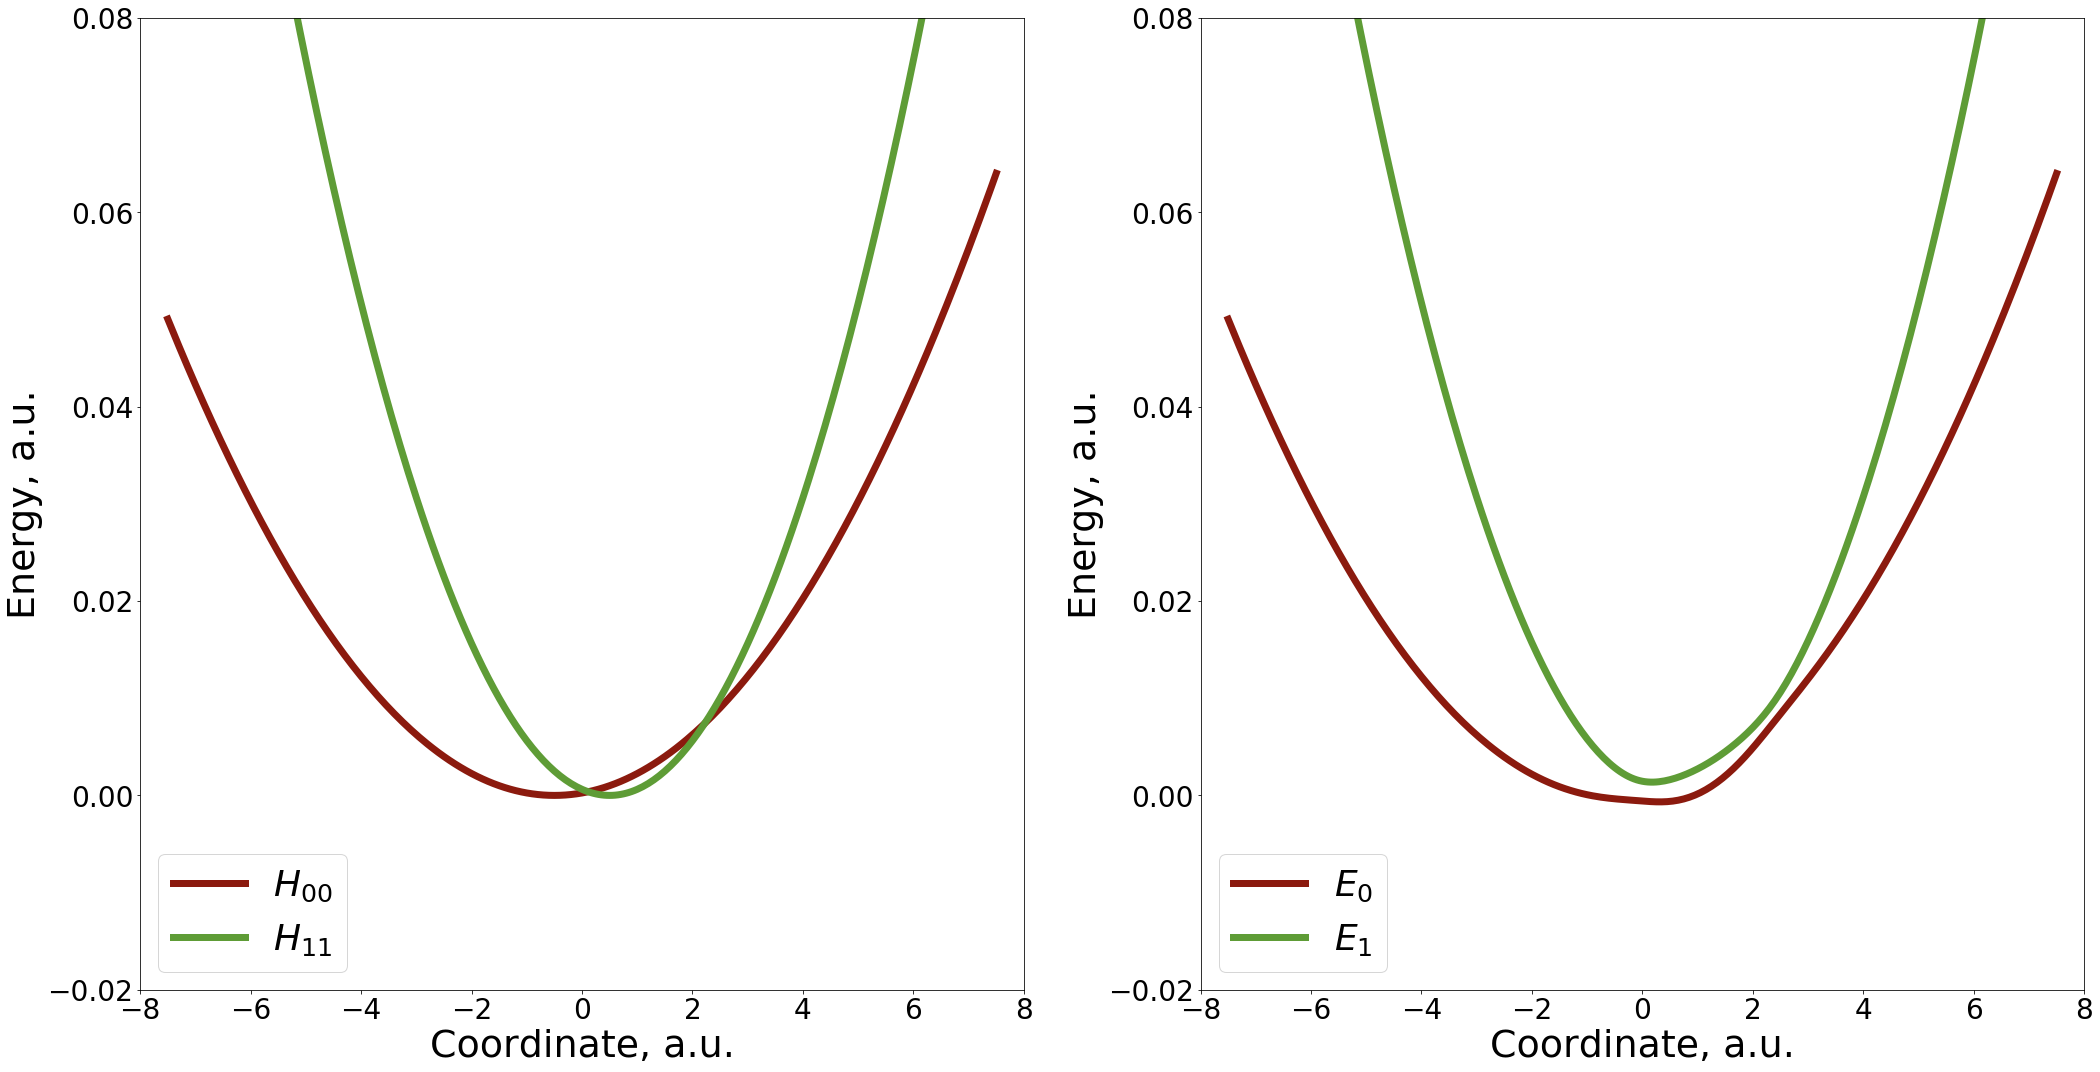

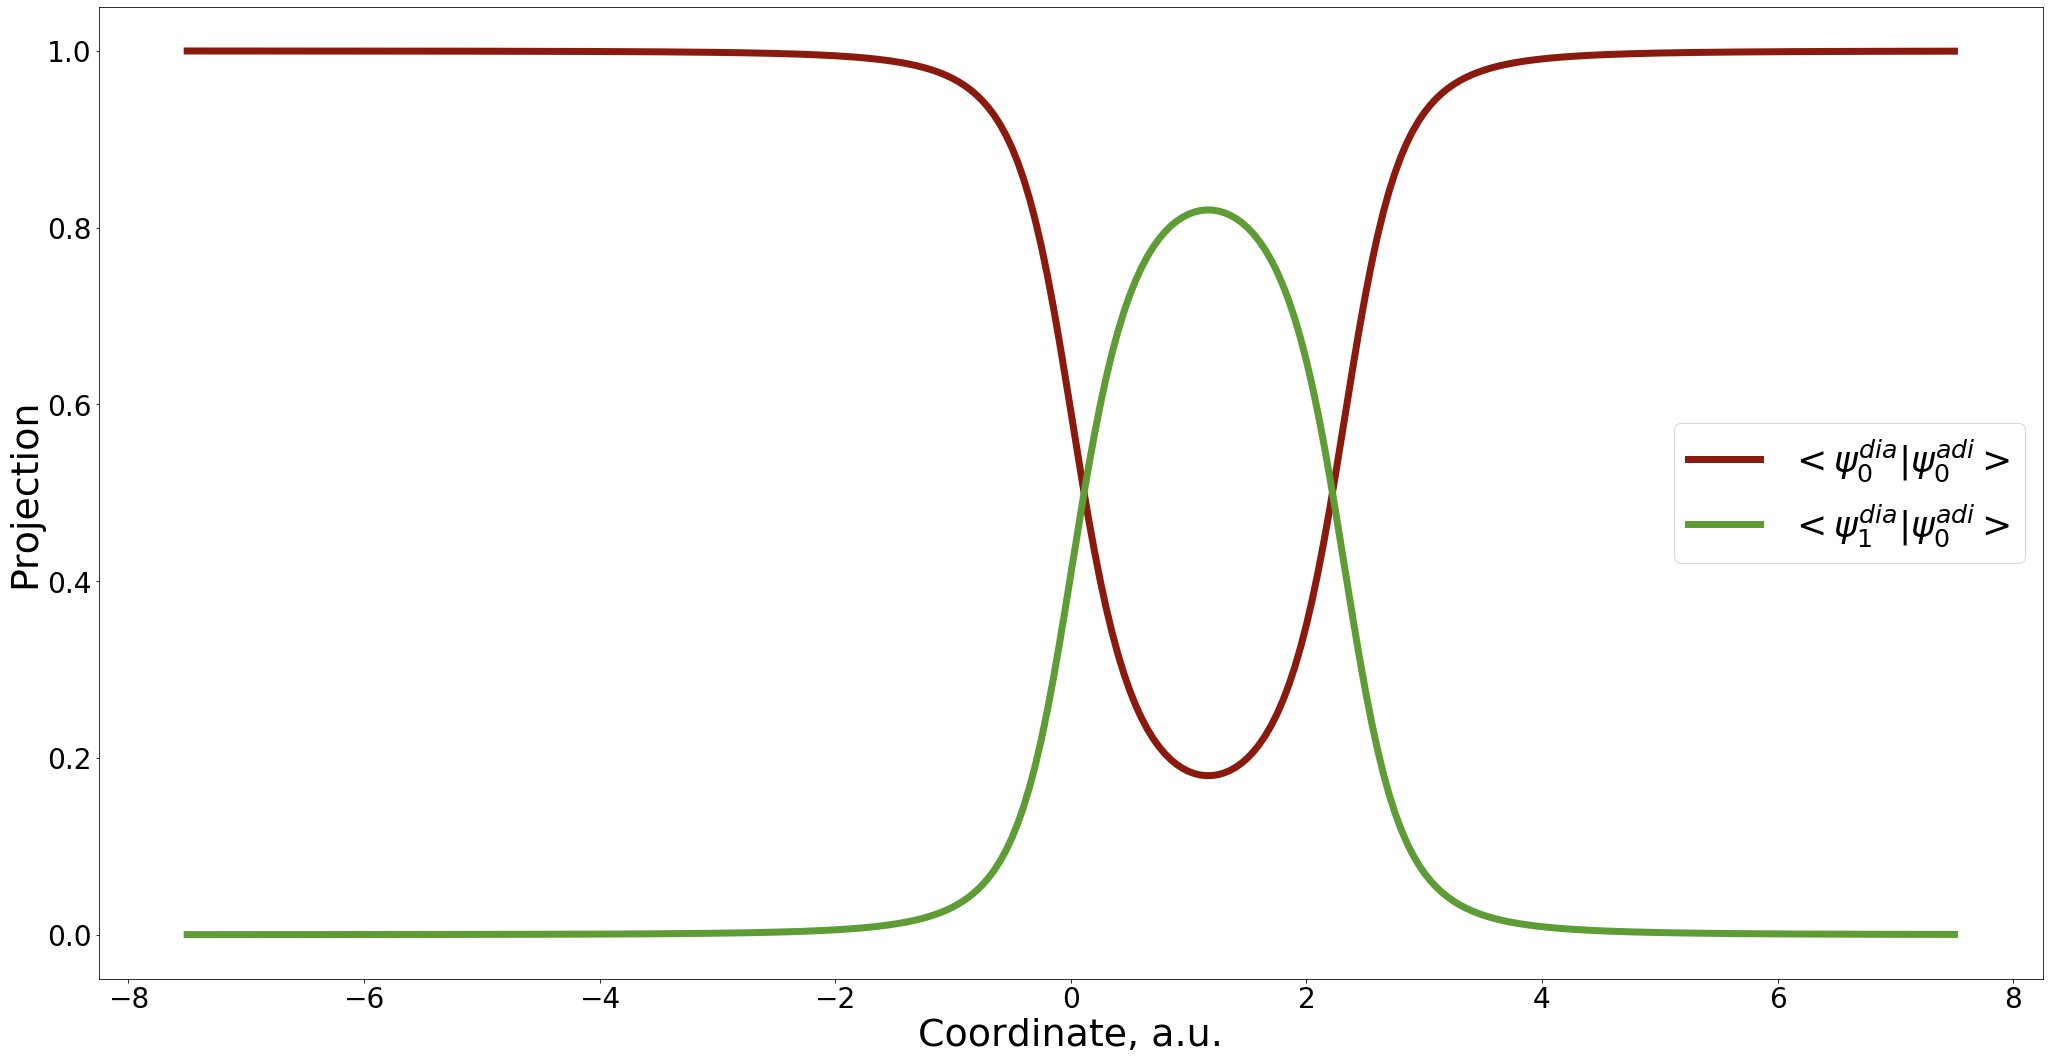

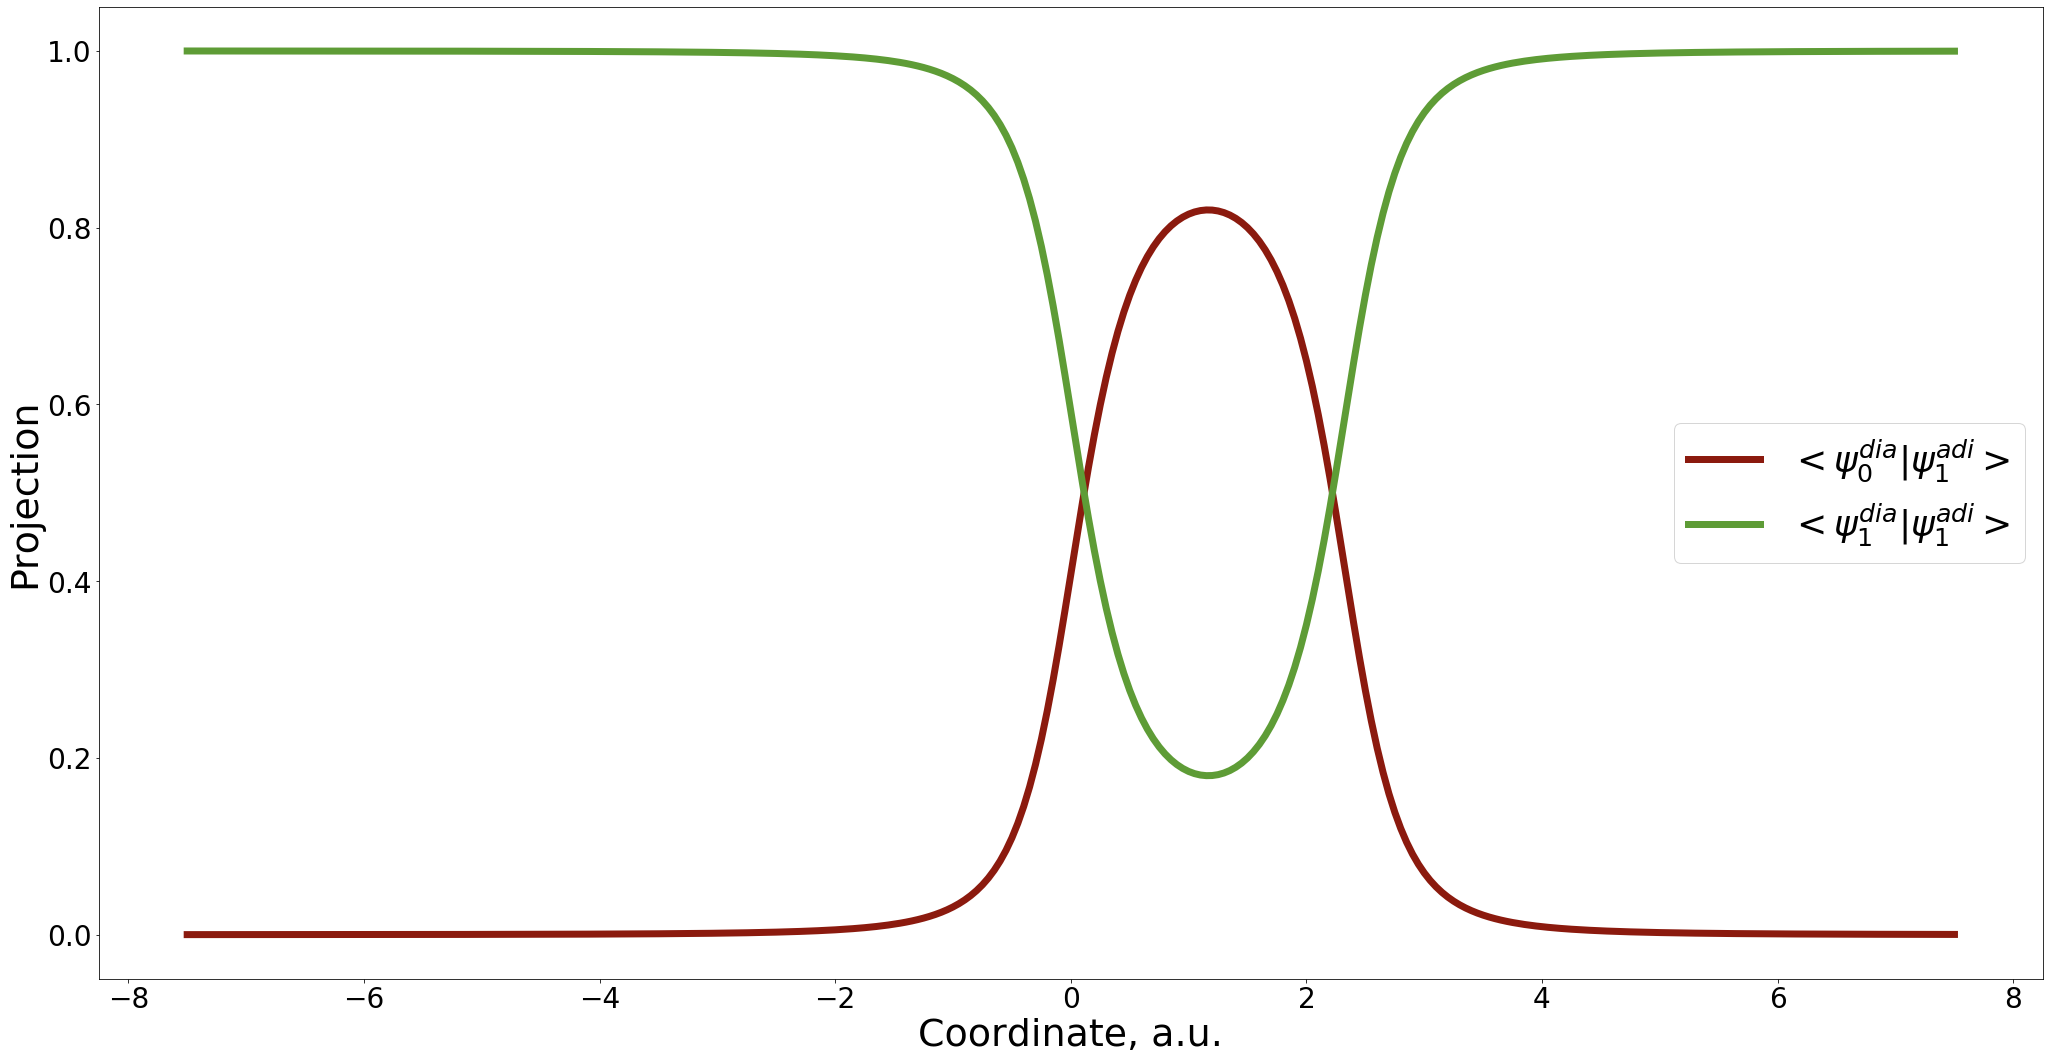

In [4]:
model_params = {"model":1,
                "E_n":[0.0,  0.0],
                "x_n":[-0.5, 0.5],
                "k_n":[0.002, 0.005],
                "V":0.001,
                "nstates":2}

plot_params = {"colors": colors, "clrs_index": clrs_index, "ylim":[-0.02, 0.08], "xlim":[-8, 8]}
dynamics_plotting.plot_surfaces(compute_model, [ model_params ], [0,1], -7.5, 7.5, 0.05, plot_params)

## 3. Dynamics <a name="dynamics"></a>
[Back to TOC](#TOC)

Let us first define a convenience function that would take care of the initialization of the dynamics and would setup the simulation parameters, so that we could focus on the difference of non-NBRA and NBRA dynamics later.

The detailed description of the `init_nuclear_dyn_var` function is given in [another tutorial]()

The `default_params` are only updated for the values that are different from the default values that would be set up by the `compute.run_dynamics` function. In particular, we need to **increase the level of the output, to save either the time-overlap or basis transformation matrices** in the HDF5. Doing only one of them is fine, but for the puprpose of this tutorial we will save both of them at once, to be used in two scenarios.

<a name="generic-recipe"></a><a name="init_nuclear_dyn_var"></a><a name="random"></a>

In [5]:
def run_tsh(common_params, model_params, prefix):
    
    params = dict(common_params)
        
    
    # Random numbers generator object
    rnd = Random()
    
    #============ Initialize dynamical variables ==================
    x0 = params["x0"]
    p0 = params["p0"]
    masses = params["masses"]
    k0 = params["k"]
    ntraj = params["ntraj"]
    nstates = params["nstates"]
    
    # Nuclear
    init_nucl = {"init_type":2, "force_constant":k0, "ntraj":ntraj}
    #init_nucl = {"init_type":3, "force_constant":k0, "ntraj":ntraj}
    q, p, iM = tsh_dynamics.init_nuclear_dyn_var(x0, p0, masses, init_nucl, rnd)
    
    # Electronic
    istate = params["istate"]
    istates = []
    for i in range(nstates):
        istates.append(0.0)
    istates[ istate[1] ] = 1.0    
    _init_elec = { "init_type":3, "nstates":nstates, "istates":istates, "rep":istate[0],  "ntraj":ntraj   }

    
    #============= Dynamical variables ==============
    dyn_params = dict(common_params)
    
    # This should update only the properties that aren't defined, but not override the existing values!
    critical_params = [  ]     
    default_params = { "prefix":prefix, "mem_output_level":4 }     
    comn.check_input(dyn_params, default_params, critical_params)
                    
    _model_params = dict(model_params)
    _model_params.update({"model0": model_params["model"] })
    
    start = time.time()                               
    res = tsh_dynamics.generic_recipe(q, p, iM, dyn_params, compute_model, _model_params,_init_elec, rnd)
    end = time.time()    
    print(F"Calculation time = {end - start} seconds")


## 3.1. The NBRA TSH dynamics workflow <a name="dynamics-nbra-fssh"></a>
[Back to TOC](#TOC)

It consists of 2 steps:

* [Step 1](#adiabatic-dynamics) precomputing the nuclear trajectories and the properties such as time-overlaps and Hvib along the trajectories
* [Step 2](#nbra-fssh) using these results as the input to the dynamics. We assume that can read pre-computed NACs from the files. However, these NACs could be "raw" and we'd need to include the phase correstion/state tracking. For these purposes, we need to supply our workflow with the time-overlap matrices, which can be done in two ways:
  - [Method 1](#nbra-fssh-1) by computing time-overlaps from the wavefunctions (need the basis transformations)
  - [Method 2](#nbra-fssh-2) by simply reading the precomputed matrices
  

First, let set up the common parameters for all runs, such as masses and initial position/momenta of the particles, the number of timesteps, initial states, etc.

In [6]:
common_params = { "nsteps":1000, "dt":10.0, 
                  "ntraj":25, "x0":[-4.0], "p0":[4.0], "masses":[2000.0], "k":[0.01],                  
                  "nstates":2, "istate":[1, 0],
                  "which_adi_states":range(2), "which_dia_states":range(2)
                }

The NBRA utalizes a precomputed nuclear trajectory. Therefore we need two steps
1. Precompute the nuclear trajectory using   
    `tsh_method`: -1   for adiabatic dynamics   
    `force_method`: 1 state-specific forces)
    Here, we will save the informaiton along the precomputed trajectory in a hdf file


2. Run the NA dynamics  
    `tsh_method`:0  not -1, to allow hops   
    `force_method`: no forces - ballistic motion q ~ t 
    The key is that at this stage, the dynamical data should be precomputed. Therefore, we have to read the
    precomputed data. What one cna do, is to have compute_model return the precomputed data as if that was the
    data that is being currently computed for a given timestep


### 3.1. Precompute the nuclear trajectory - adiabatic dynamics on the ground state<a name="adiabatic-dynamics"></a>
[Back to TOC](#TOC)
    
[Back to NBRA FSSH workflow](#dynamics-nbra-fssh)
    
First, to run the adiabatic dynamics, we set `tsh_method = -1`, to exclude surface hopping. Note that that the TD-SE will still be integrated to determine the corresponding state populations. For this run type, we can just rely on the default parameters.
    
    
The results will be stored in the "adiabatic_md" folder.
    
**IMPORTANT:** 

To be able to run the calculations below, one needs to generate vibronic Hamiltonian data along the trajectories first. To do this, one needs to set ``"mem_output_level:4"``, as already done in the axusiliary `run_tsh` function above.

In [7]:
params_adiabatic = dict(common_params)
params_adiabatic.update({ "tsh_method":-1 } )
run_tsh(params_adiabatic, model_params, "adiabatic_md")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

Now, lets plot the properties. To do this, we use the built-in convenience function `plot_dynamics`

Note:

- the total energy is well conserved - the integration is accurate

- adiabatic energy gap periodiaclly increases - this corresponds to the particle's movement away from the minima of the two PESs

- diabatic state energies are irrelevant here (not shown), so may be disregarded

- coordinate-vs-time and the phase space portrait suggest periodic, but anharmonic motion

- the SE populations evolve, since we still integrate the TD-SE, but that doesn't affect the state transitions - we still stay on one adiabatic state

- the SH populations do not change - no hops, as we expect for the adiabatic dynamics

- time-overlaps and projectors vary from +1 to -1 occasionally, which indicates that phase inconsistencies sometimes occur, but there are no state identity changes. This is also consistent with the observation that the "raw" and "dynamically-consistent" populations coinside for all times

<a name="plot_dynamics"></a>

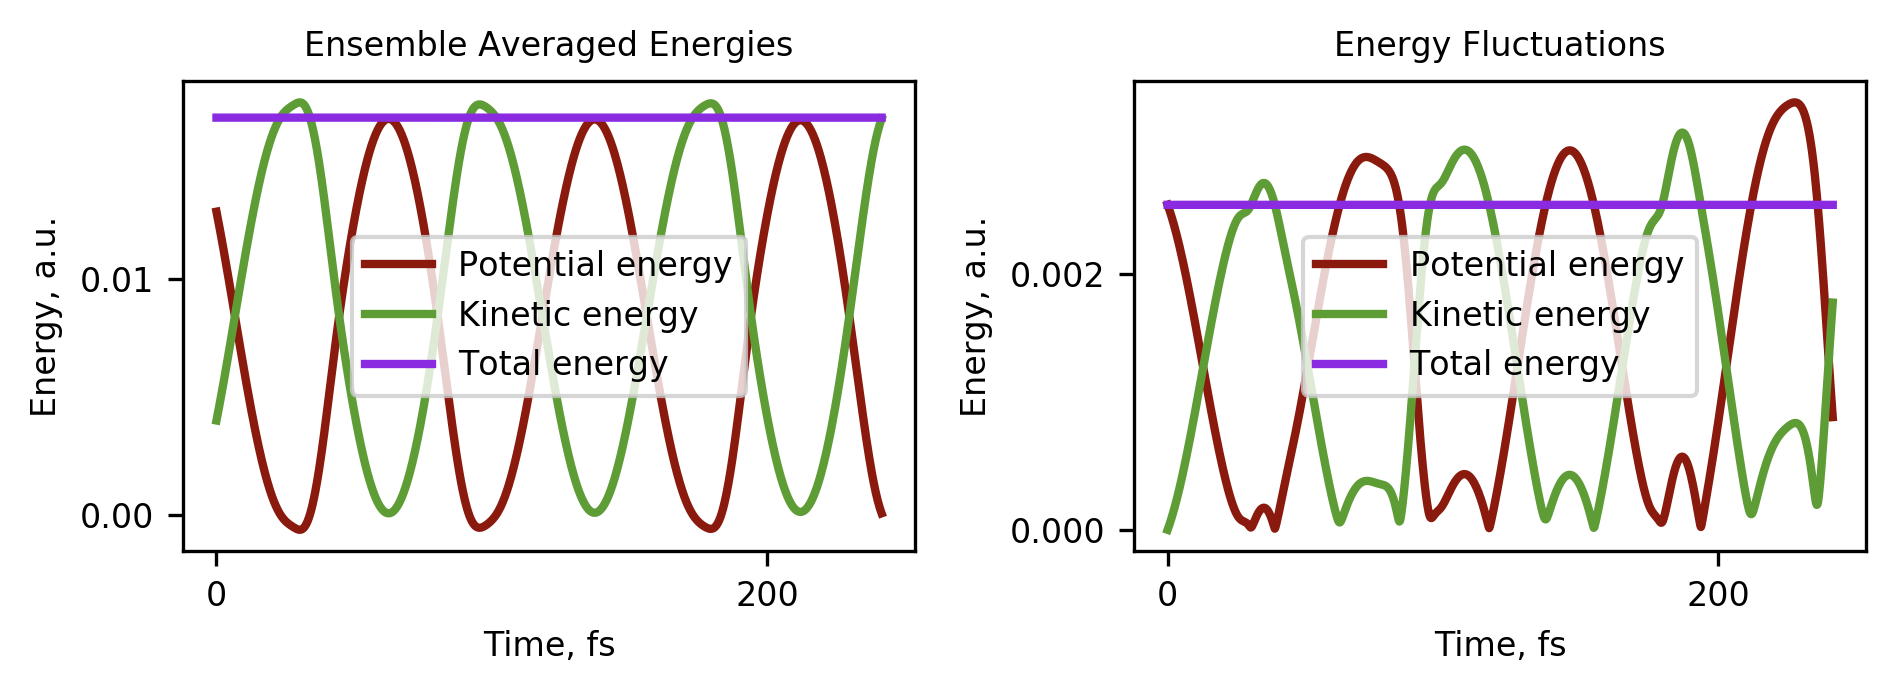

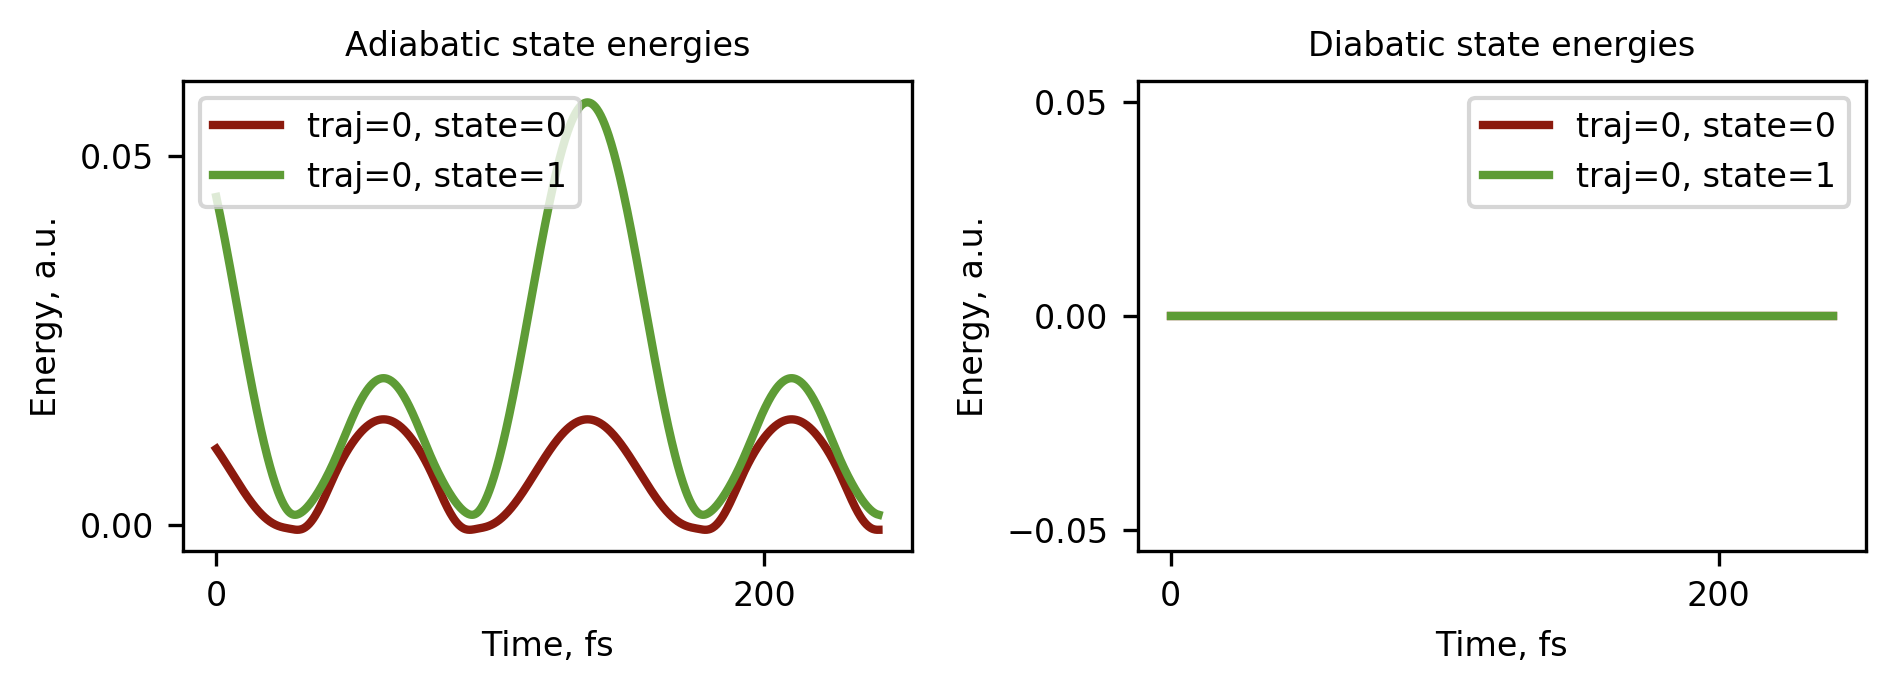

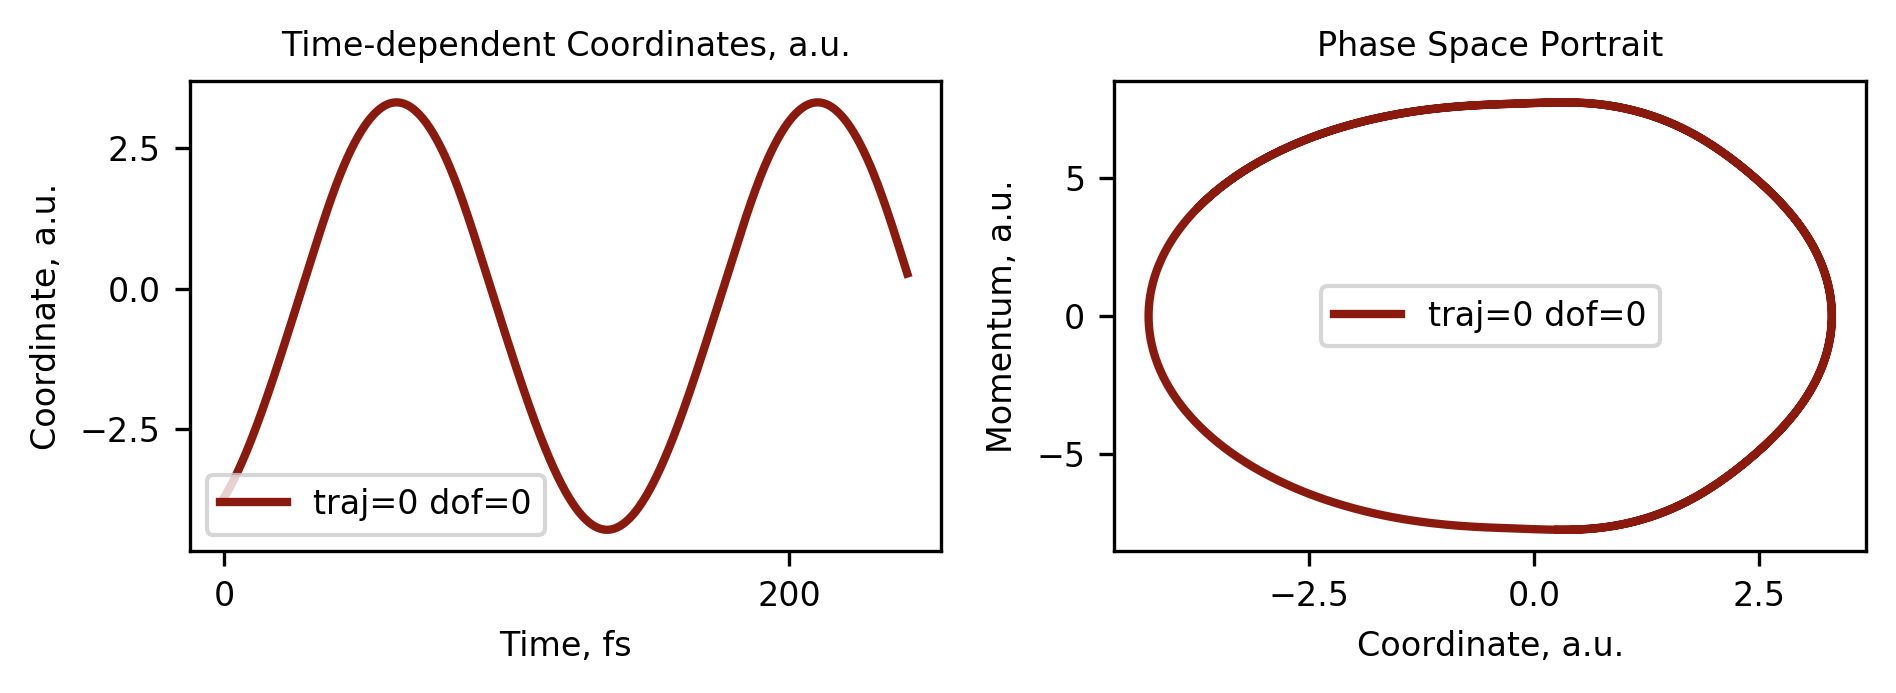

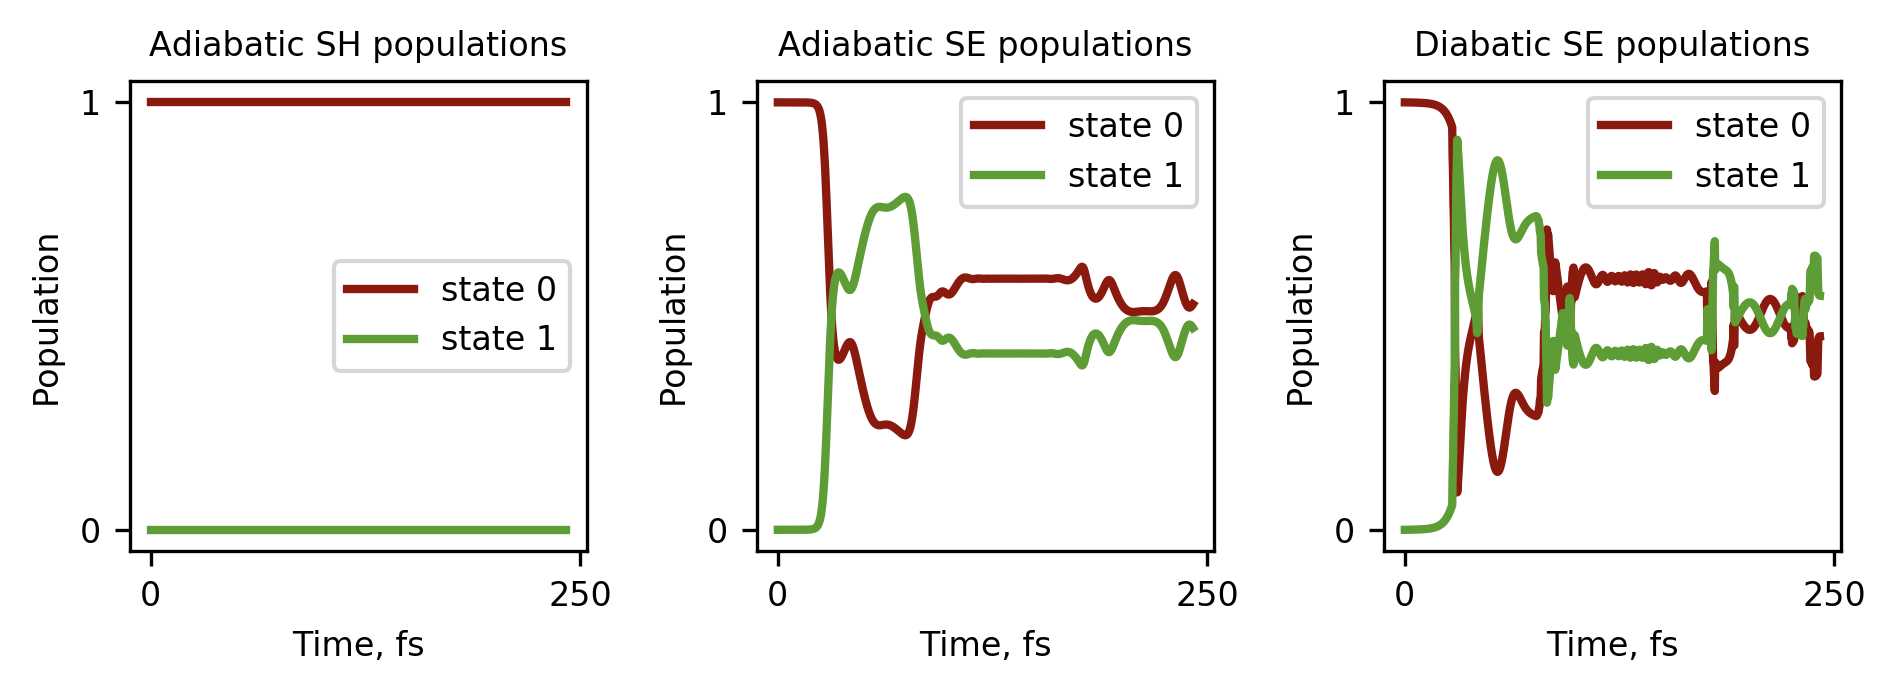

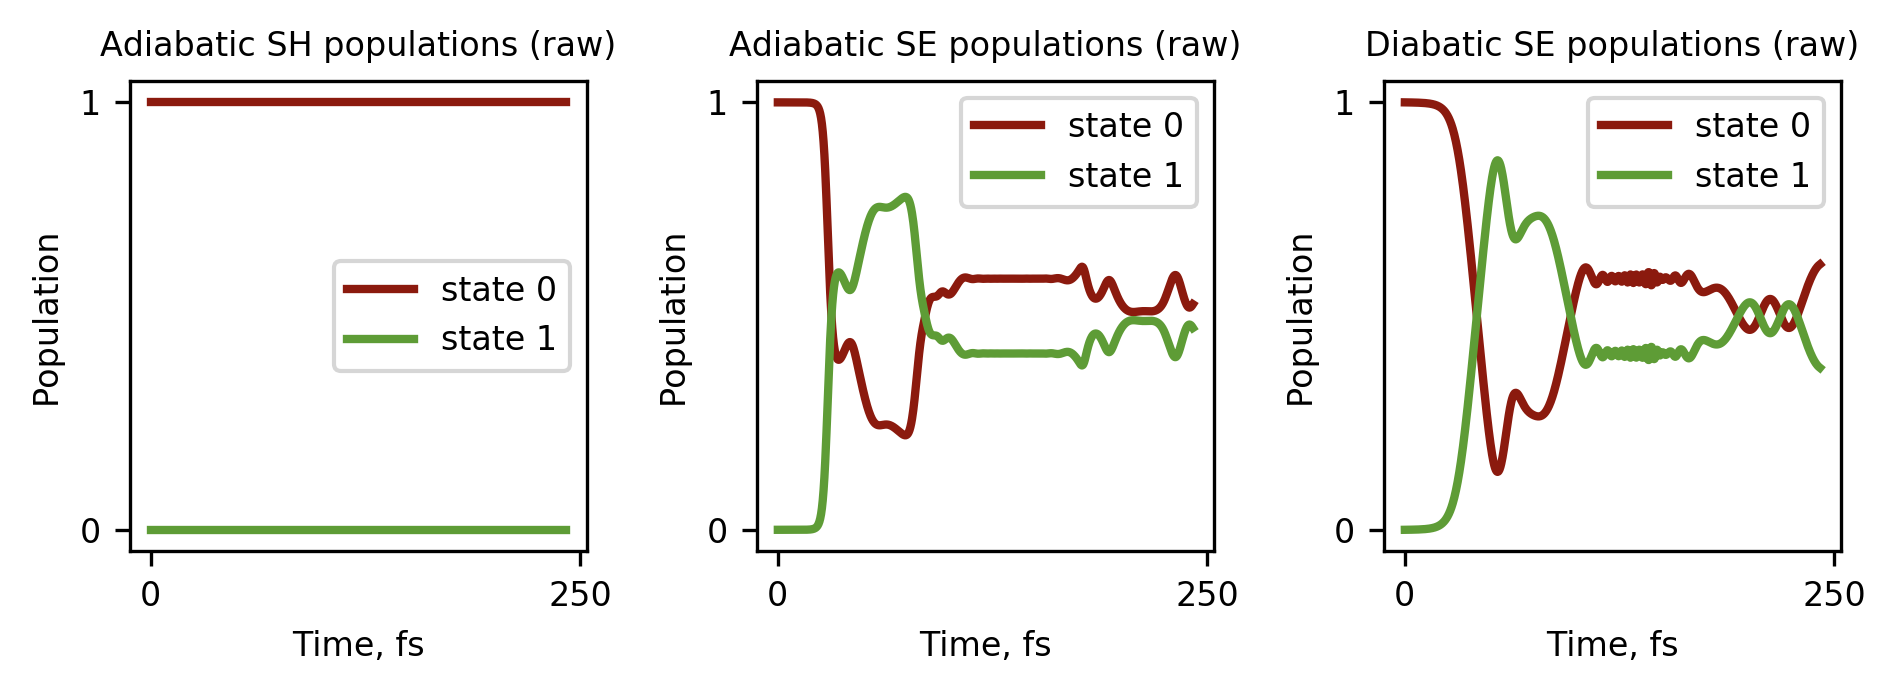

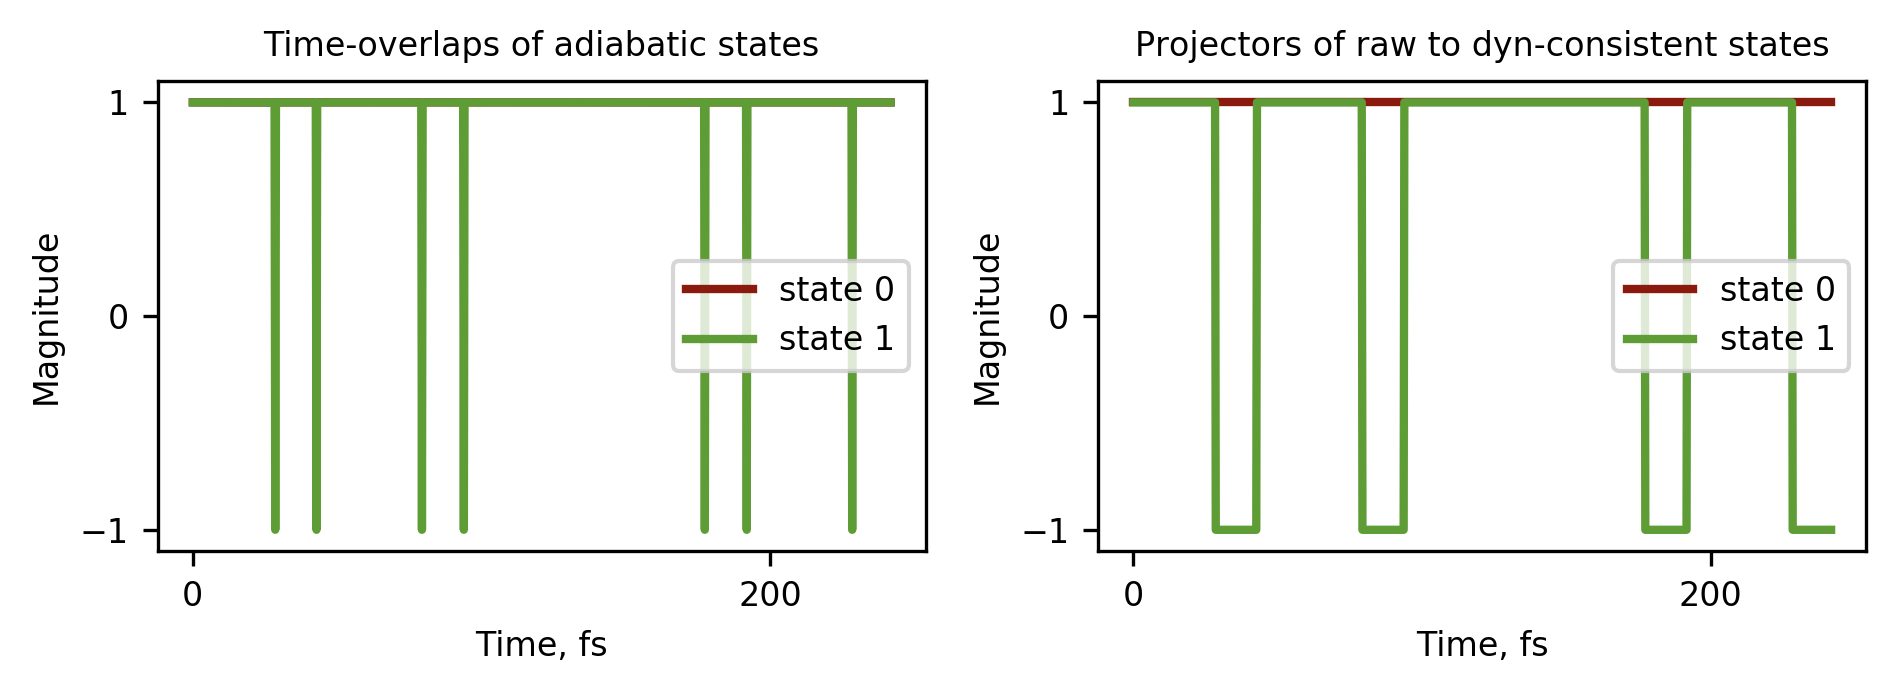

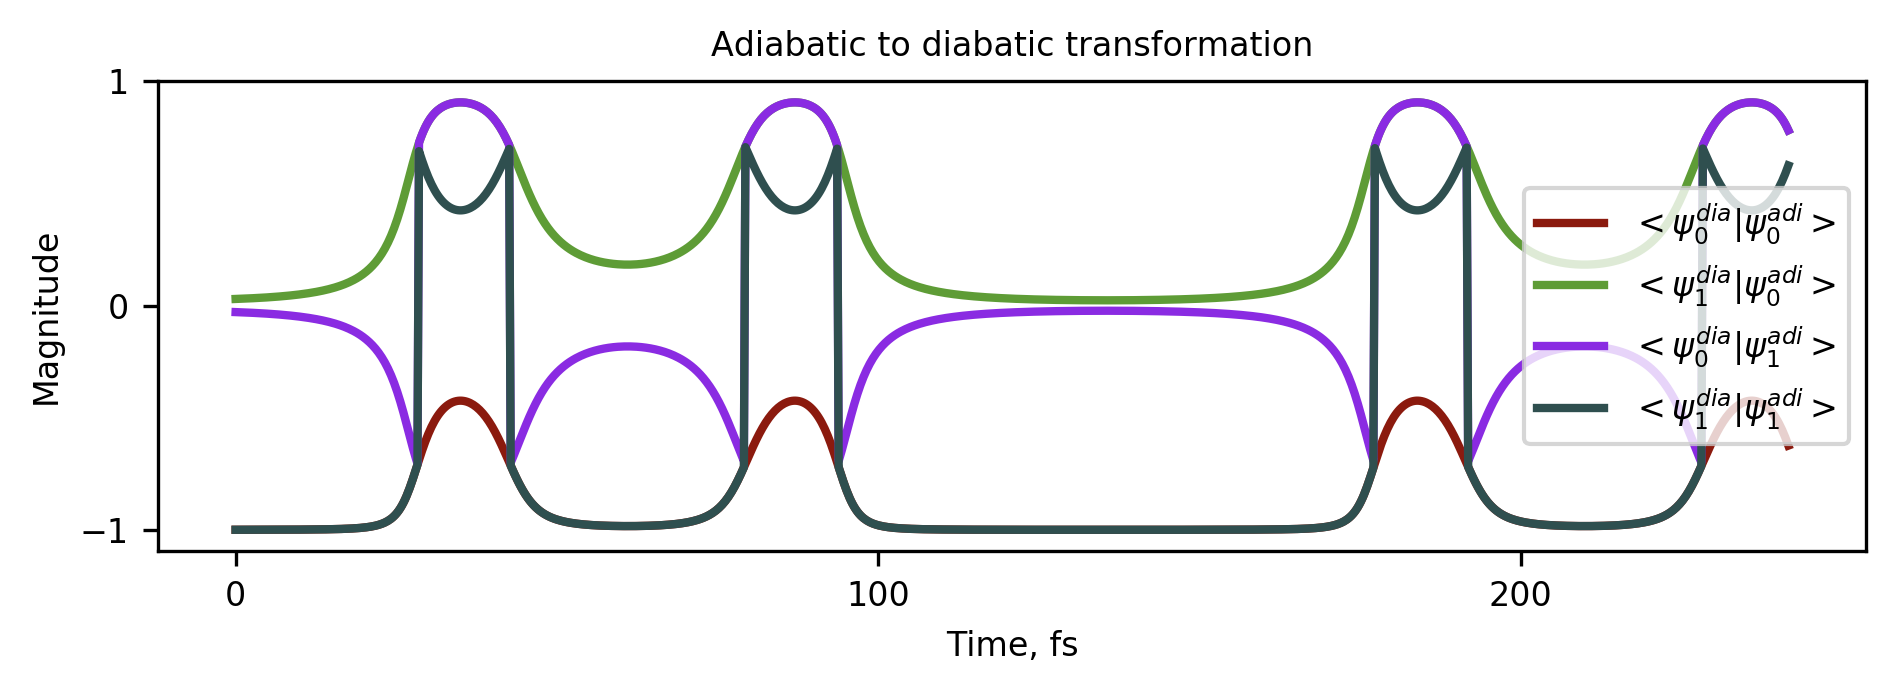

In [16]:
plot_params = { "prefix":"adiabatic_md", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0],
                "which_adi_states":[0,1], "which_dia_states":[0,1],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

<a name="all_add_functions"></a>
The `plot_dynamics` function is a convenient one for plotting multiple panels to characterise various aspects of the dynamics. It has many options to be customised to your needs. However, sometimes you may not need all the panels or you may not have all the information to plot all of them. In these situations, it is good to know that the function is build of the calls of other smaller functions, each of which adds the printout of the corresponding data to the plot. 

Those smaller functions are defined in the `libra_py.dynamics.tsh.plot` module and can be pretty handy in some situations. 

Here is a list of what is available at the time the tutorial is prepared (it may change in the future though, so you are better off checking out the documentation):

* `add_energies(plt, hdf_file, plot_params_, property_type)`
* `add_trajectory_resolved_ham_property(plt, hdf_file, plot_params_, ham_property_type)`
* `add_cooordinates_vs_t(plt, hdf_file, plot_params_)`
* `add_momenta_vs_t(plt, hdf_file, plot_params_)`
* `add_phase_space(plt, hdf_file, plot_params_)`
* `add_populations(plt, hdf_file, plot_params_, pop_type )`
* `add_time_overlaps_projectors(plt, hdf_file, plot_params_, prop_type)`
* `add_basis_transform(plt, hdf_file, plot_params_)`

Lets look how they can be used. You basically:

1. open the HDF5 files produced by Libra

        with h5py.File(F"{prefix}/{filename}", 'r') as f:
    
    
2. initialize the figure

        plt.figure(num=None, figsize=plot_params["figsize"], dpi=plot_params["dpi"], 
                   edgecolor='black', frameon=plot_params["frameon"])  
                   
3. add a subplot

        plt.subplot(1,2,1)
        
4. add the corresponding data plotting to that subplot by calling one of those functions     

        tsh_dynamics_plot.add_time_overlaps_projectors(plt, f, plot_params, "St")
        
5. then, optionally, you may want to save the figures shown

        plt.savefig(F"{out_prefix}/St-projectors-vs-t.png", dpi=plot_params["dpi"])
        

So, here is how we could for instance print the time-overlaps and projectors

<a name="add_time_overlaps_projectors"></a><a name="add_basis_transform"></a><a name="read-to-plot"></a>

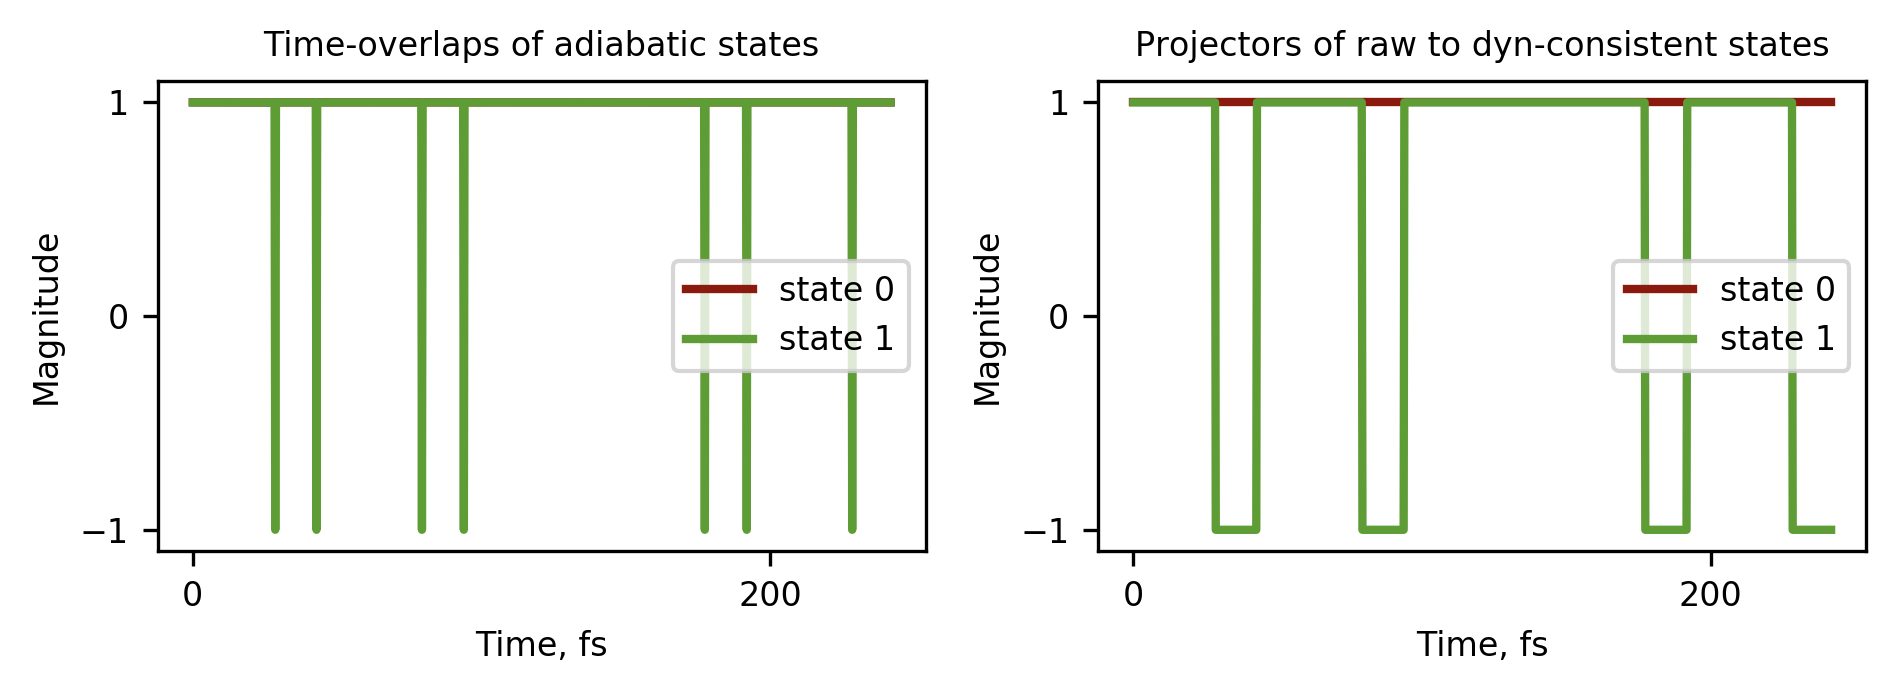

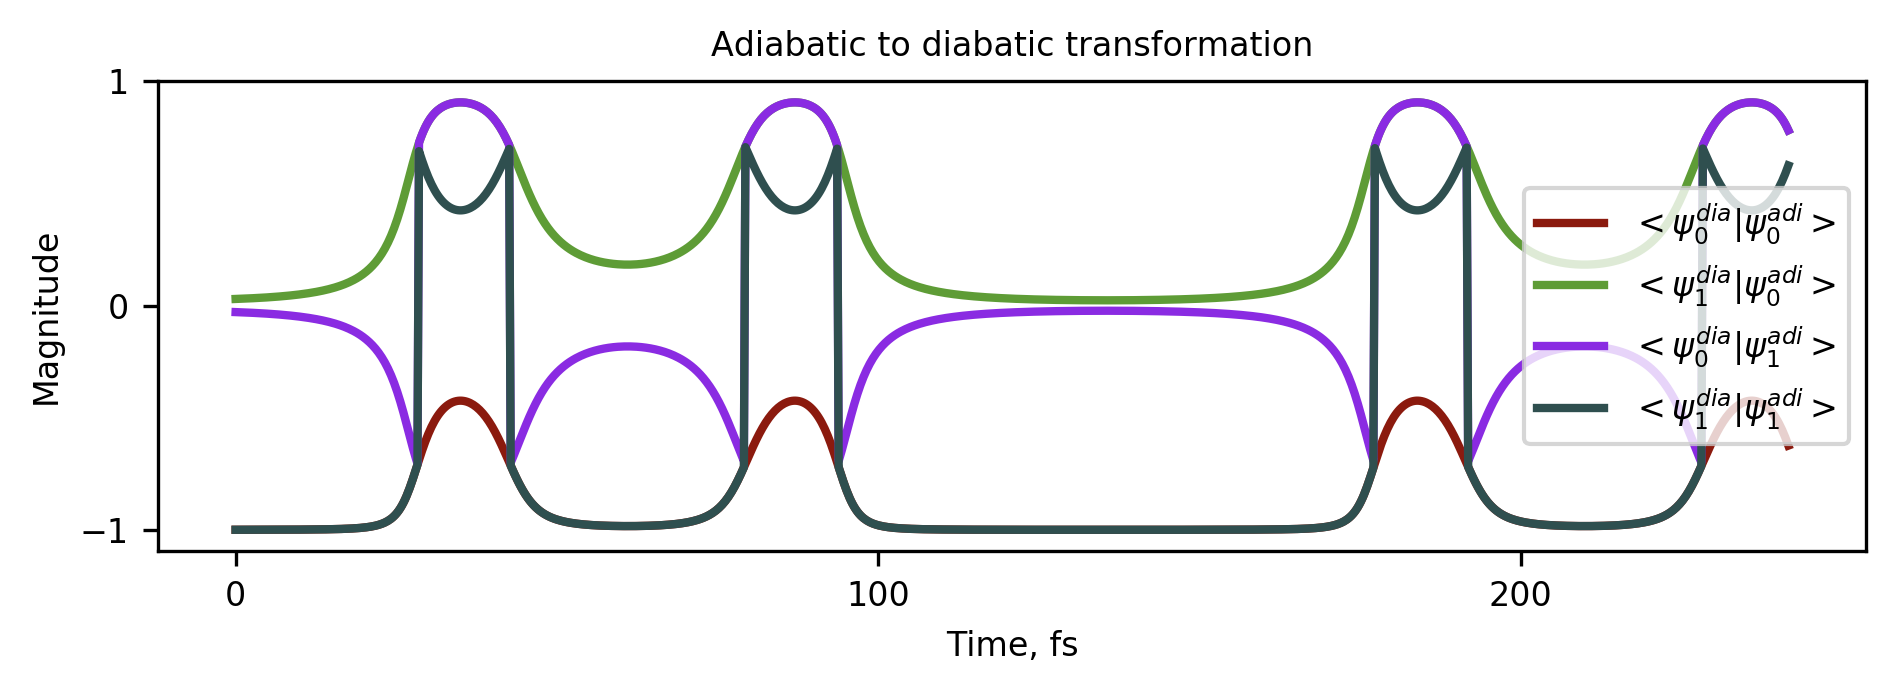

In [9]:
def custom_plot(plot_params_):
    
    plot_params = tsh_dynamics_plot.common_defaults(plot_params_)
            
    filename           = plot_params["filename"]
    prefix             = plot_params["prefix"]
    output_level       = plot_params["output_level"]
    which_dofs         = plot_params["which_dofs"]
    which_trajectories = plot_params["which_trajectories"]
    which_adi_states   = plot_params["which_adi_states"]
    which_dia_states   = plot_params["which_dia_states"]
    out_prefix = prefix
    
    axes_fontsize = plot_params["axes_fontsize"]
    axes_label_fontsize = plot_params["axes_label_fontsize"]
    legend_fontsize = plot_params["legend_fontsize"]
    title_fontsize = plot_params["title_fontsize"]
    xlim = plot_params["xlim"]
    ylim = plot_params["ylim"]
    Lw = plot_params["linewidth"]
    

    with h5py.File(F"{prefix}/{filename}", 'r') as f:
        
        #===== Time-overlaps and projectors =========
        plt.figure(num=None, figsize=plot_params["figsize"], dpi=plot_params["dpi"], 
                   edgecolor='black', frameon=plot_params["frameon"])  
        
        plt.subplot(1,2,1)
        tsh_dynamics_plot.add_time_overlaps_projectors(plt, f, plot_params, "St")
        plt.subplot(1,2,2)
        tsh_dynamics_plot.add_time_overlaps_projectors(plt, f, plot_params, "projector")
        
        if plot_params["save_figures"]==1:
            plt.savefig(F"{out_prefix}/St-projectors-vs-t.png", dpi=plot_params["dpi"])
        
        
        #===== Basis transforms =========
        plt.figure(num=None, figsize=plot_params["figsize"], dpi=plot_params["dpi"], 
                   edgecolor='black', frameon=plot_params["frameon"])          
        plt.subplot(1,1,1)
        tsh_dynamics_plot.add_basis_transform(plt, f, plot_params)
                
        if plot_params["save_figures"]==1:
            plt.savefig(F"{out_prefix}/basist_transform-vs-t.png", dpi=plot_params["dpi"])            

            
custom_plot(plot_params)

Wasn't it simple?

### 3.2. Compute FSSH within the NBRA<a name="nbra-fssh"></a>
[Back to TOC](#TOC)
    
[Back to NBRA FSSH workflow](#dynamics-nbra-fssh)
    
    
Now, we have the data for the precomputed nuclear trajectory stored in the "mem_data.hdf" file in the "adiabatic_md" folder

For the NBRA dynamics, we will need to edit some of the default parameters to reflect the new situation.

Namely, we set the following ones:

1. ``"rep_ham":1`` - we assume that the compute model function will return object with the adiabatic properties (in fact, we need only the vibronic Hamiltonian, but it is still in the adiabatic representation)

2. ``"force_method":0`` - to not call the calculation of forces at all.  

    **Note:** 
      Although all the forces will be zero, the fact that the initial nuclear momenta were not zero means the coordinates will change linearly in time (ballistic motion). However, these coordinates (plotted in this section) are meaningless, since the actual nuclear dynamics does not depend on electronic transitions. Instead, one should be looking at the trajectories along which the vibronic Hamiltonians are produced.

3. ``"nac_update_method":0`` - we don't really have info about the derivative couplings here, so we can't compute time-NACs this way. In addition, since we'll be reading vibronic Hamiltonians directly, we don't want them being overwritten by such updating.

4. ``"tsh_method":0`` - we are now doing the FSSH

5. ``"momenta_rescaling_algo":0`` - we don't need to rescale velocities 

6. ``"hop_acceptance_algo":31`` - the proposed hops will be accepted with the Boltzmann factor probabilities, which depend only on the energy gap and effective bath temperature.


**IMPORTANT:**

We also need to modify our ``model_params`` as follows:
1. ``"model":2`` - to call the appropriate version of the function to "compute" Hamiltonians, that is the one that will be reading in the files

2. ``"filename"`` - this variable needs to point to the files that contain the corresponding properties. In our case this is the "adiabatic_md/mem_data.hdf"


The above settings are common for the following 2 variations

 
### 3.2.1. Method 1<a name="nbra-fssh-1"></a>

In this variation, we use the default settings ``"time_overlap_method":0``, which request computing the time-overlaps directly from the wvefunctions at the adjacent timesteps, internally. 

For this version to work, the `compute_model` function must return the `basis_transform` variables (which are also available in the genuine FSSH runs). So, the following sections of the `compute_model_nbra` function are relevant:

        #=========== Basis transform, if available =====
        basis_transform = CMATRIX(nadi, nadi)            
        for i in range(nadi):
            for j in range(nadi):
                basis_transform.set(i,j, complex( f["basis_transform/data"][timestep, indx, i, j]) )             
                
    obj = tmp()
    obj.basis_transform = basis_transform

In [10]:
params_nbra_fssh = dict(common_params)

params_nbra_fssh.update({ "rep_ham":1, "force_method":0, "nac_update_method":0,
                          "tsh_method":0, "hop_acceptance_algo":31, "momenta_rescaling_algo":0 } )


model_params_nbra = dict(model_params)
model_params_nbra.update( {"filename":"adiabatic_md/mem_data.hdf", "model":2 } )


run_tsh(params_nbra_fssh, model_params_nbra, "nbra_fssh")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

Lets plot the results again.

Note:

- many of the panels show irrelevant information - because we may not have the meaningful data to plot them (this is okay, we didn't actually need those)

- coordinate-vs-time shows a ballistic motion. Don't make it confuse you - the coordinates do not matter, they are just updated according to the initial momenta, but are uncoupled from the electronic dynamics, as expected for the NBRA

- the SH populations now change - this is what we expect. Also, note that they are quite close to the corresponding SE populations, which sort of makes sense since there is no back-reaction, so you may expect the two quantities to be similar. 

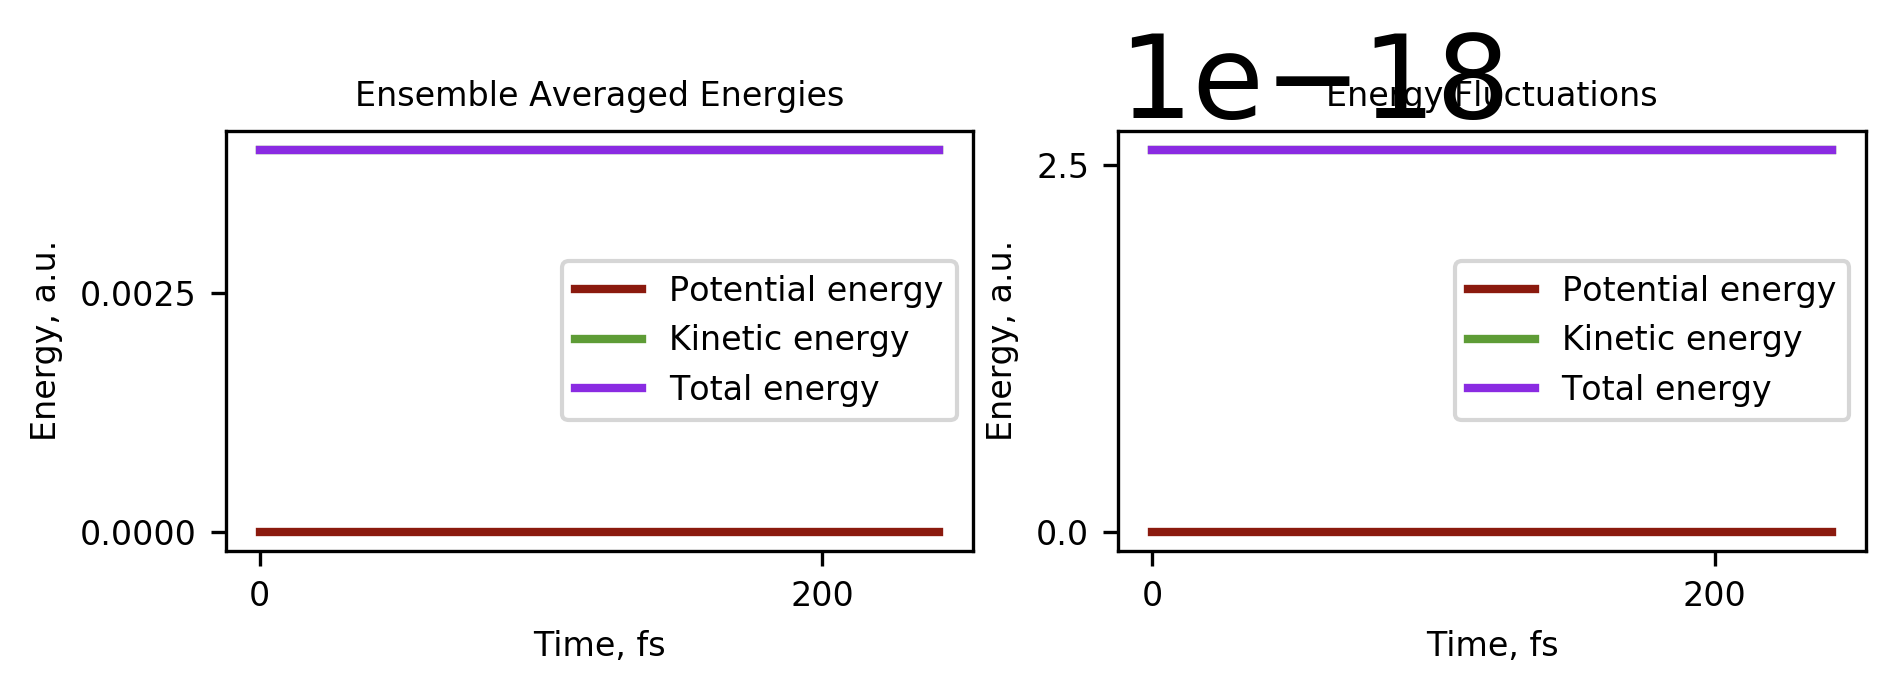

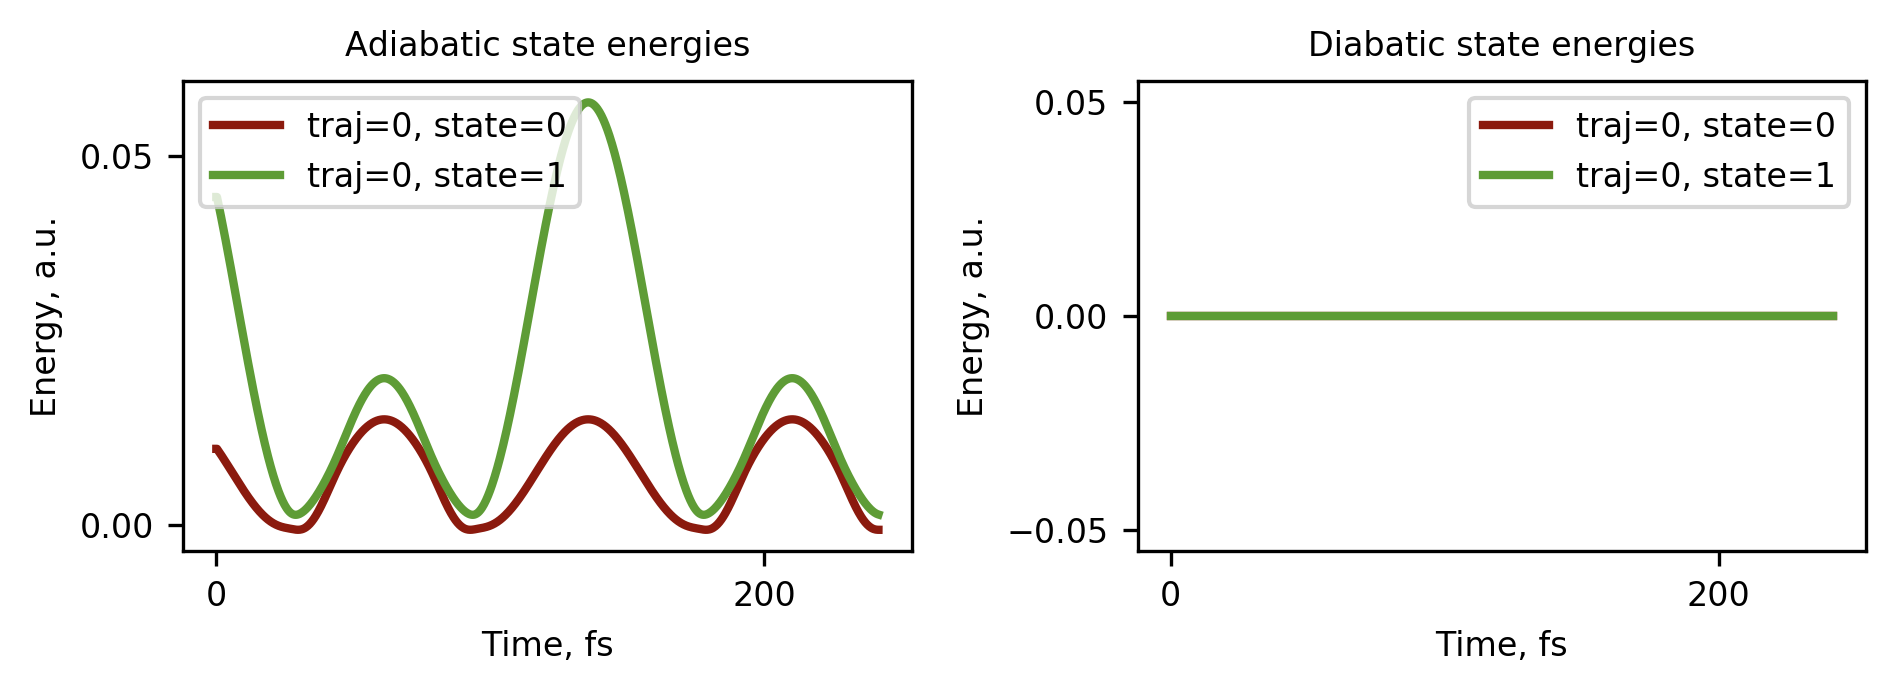

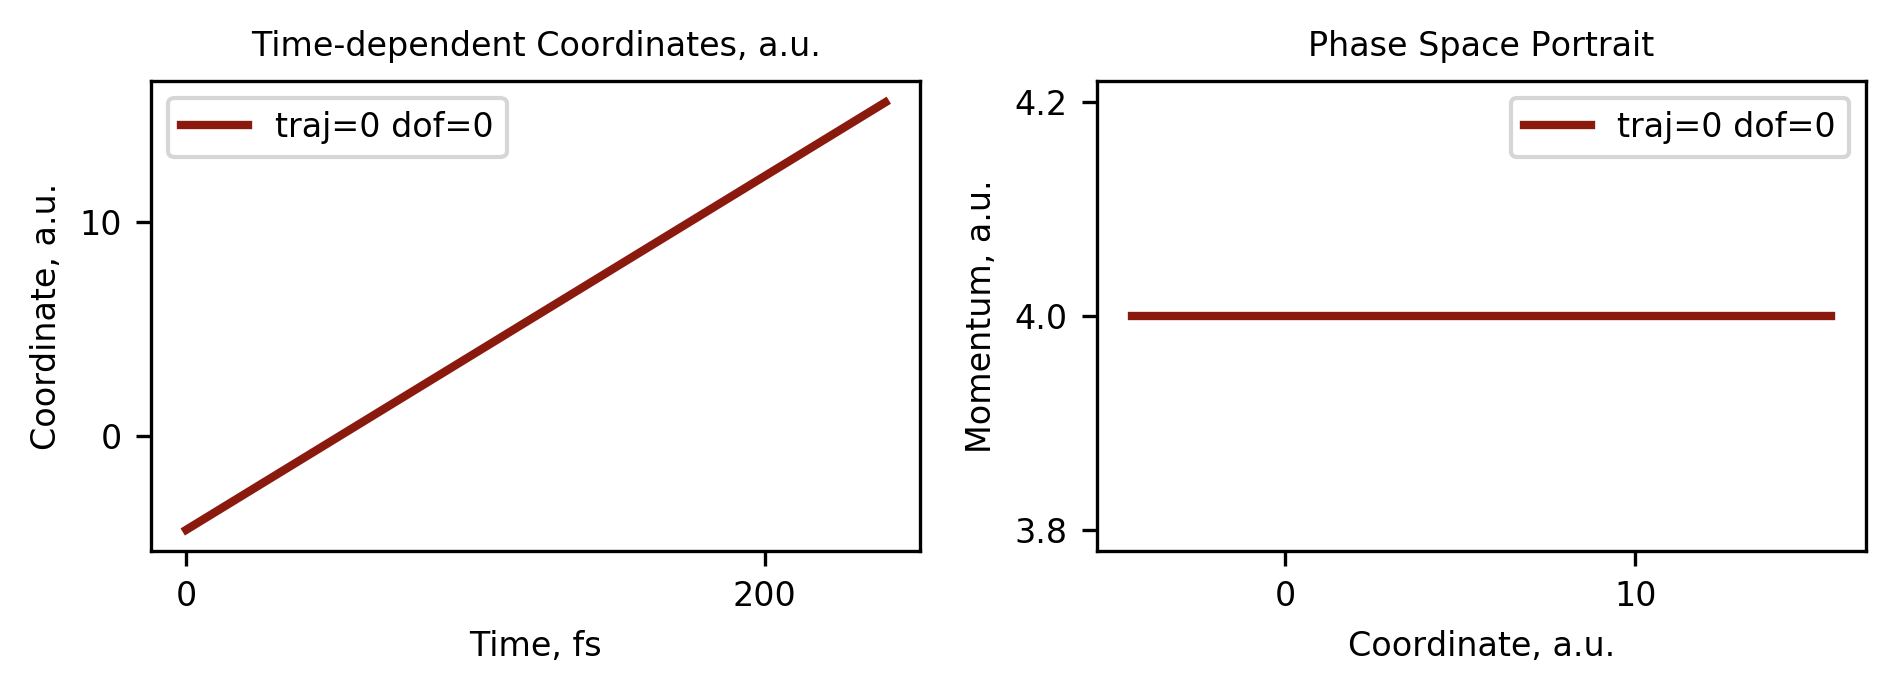

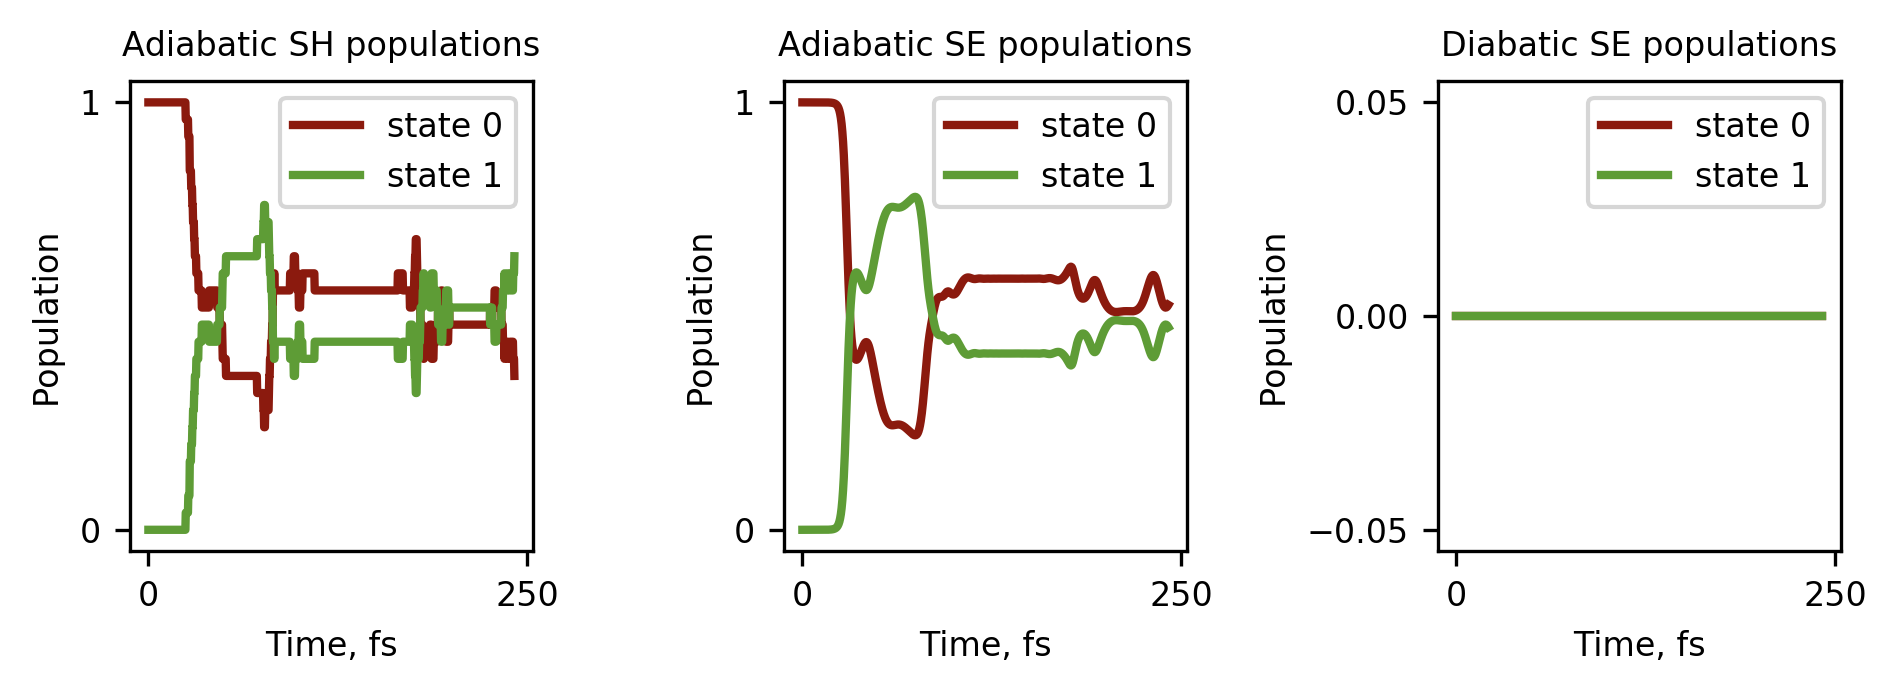

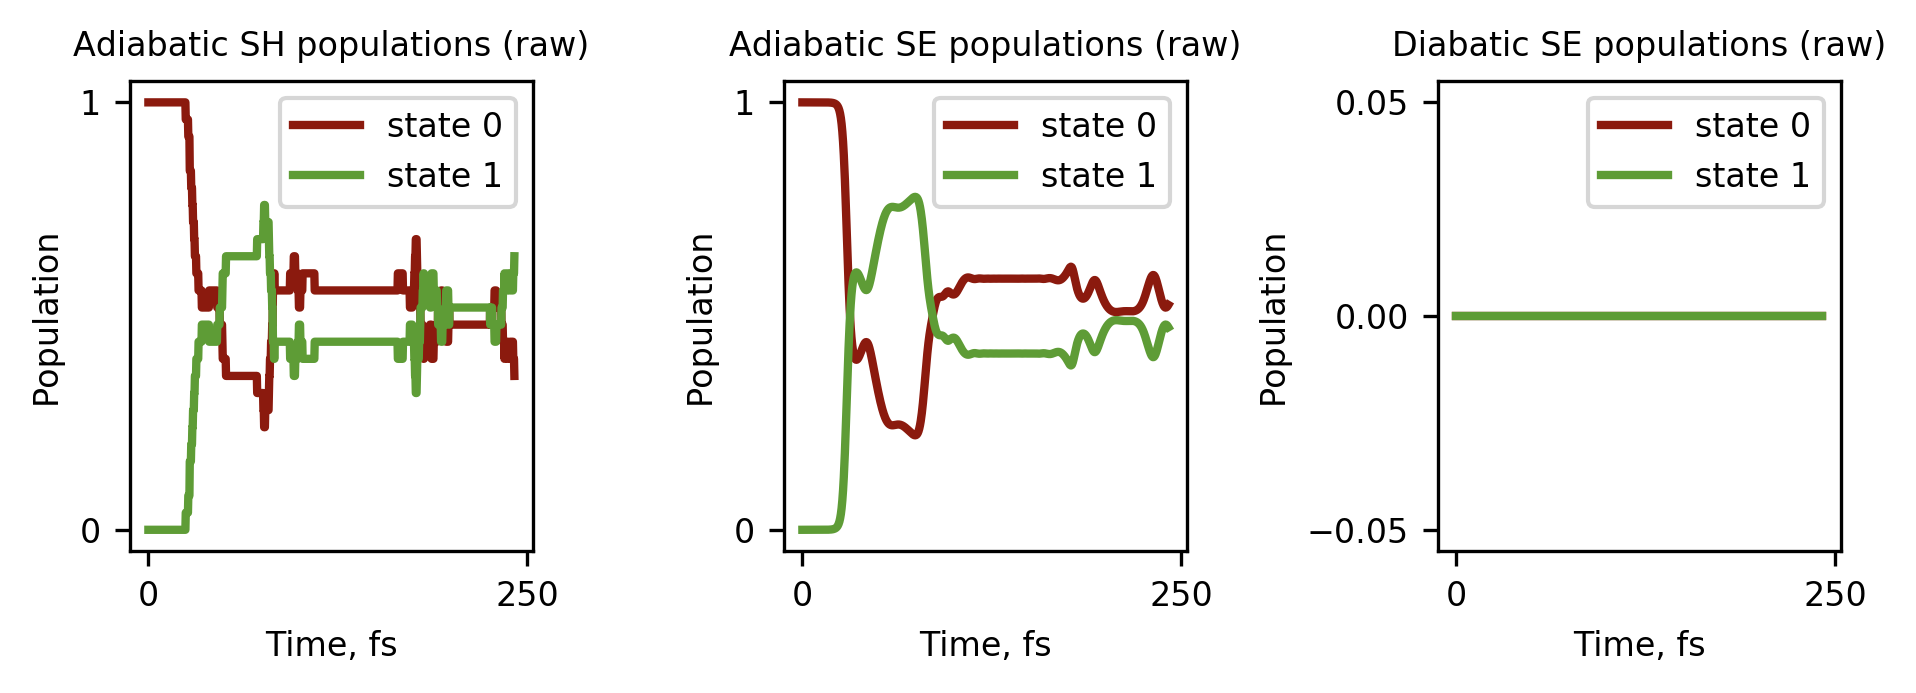

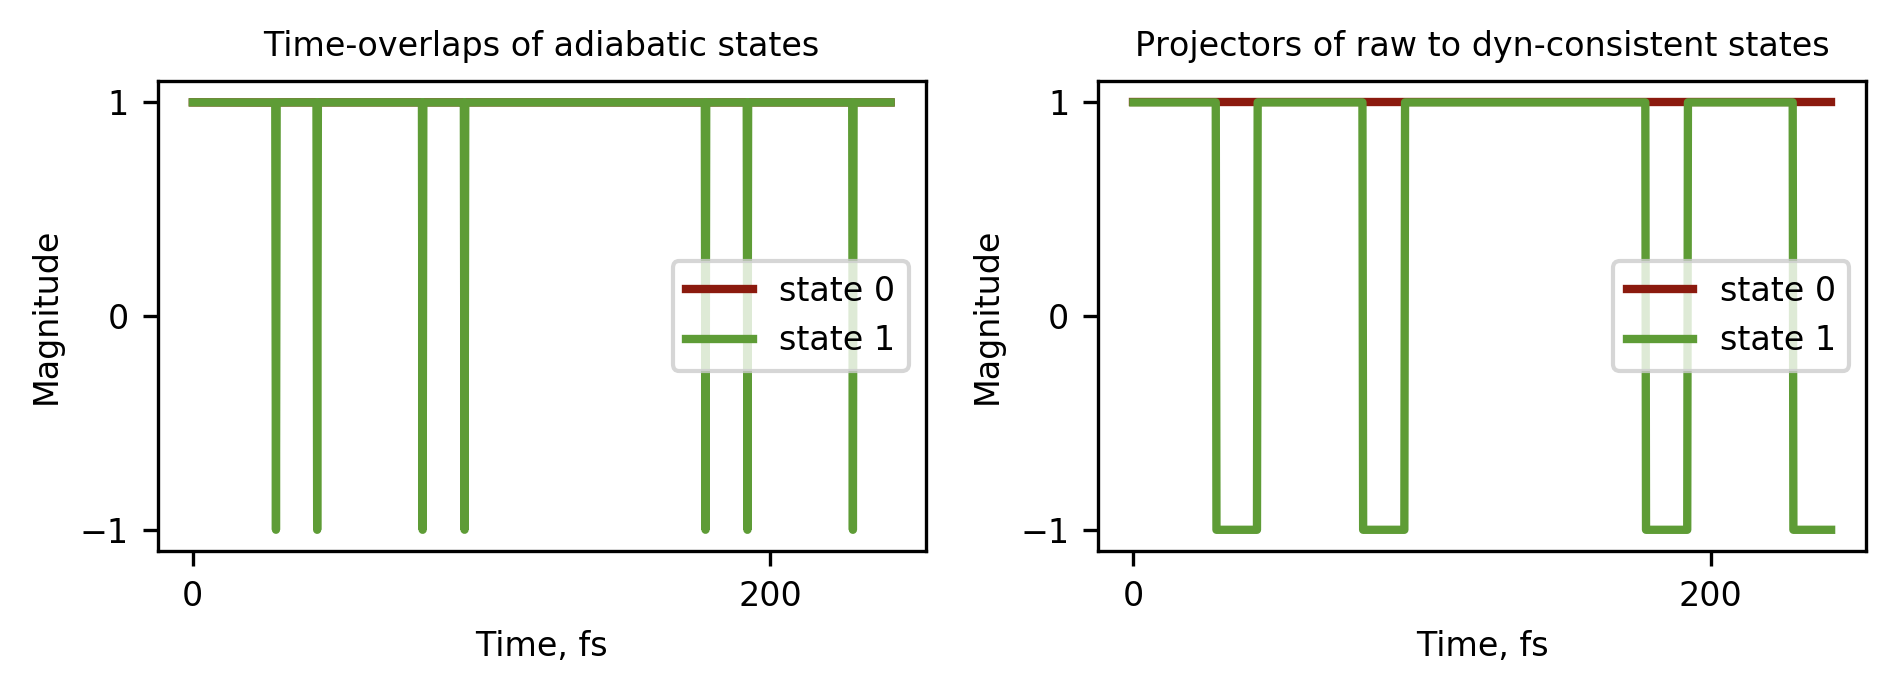

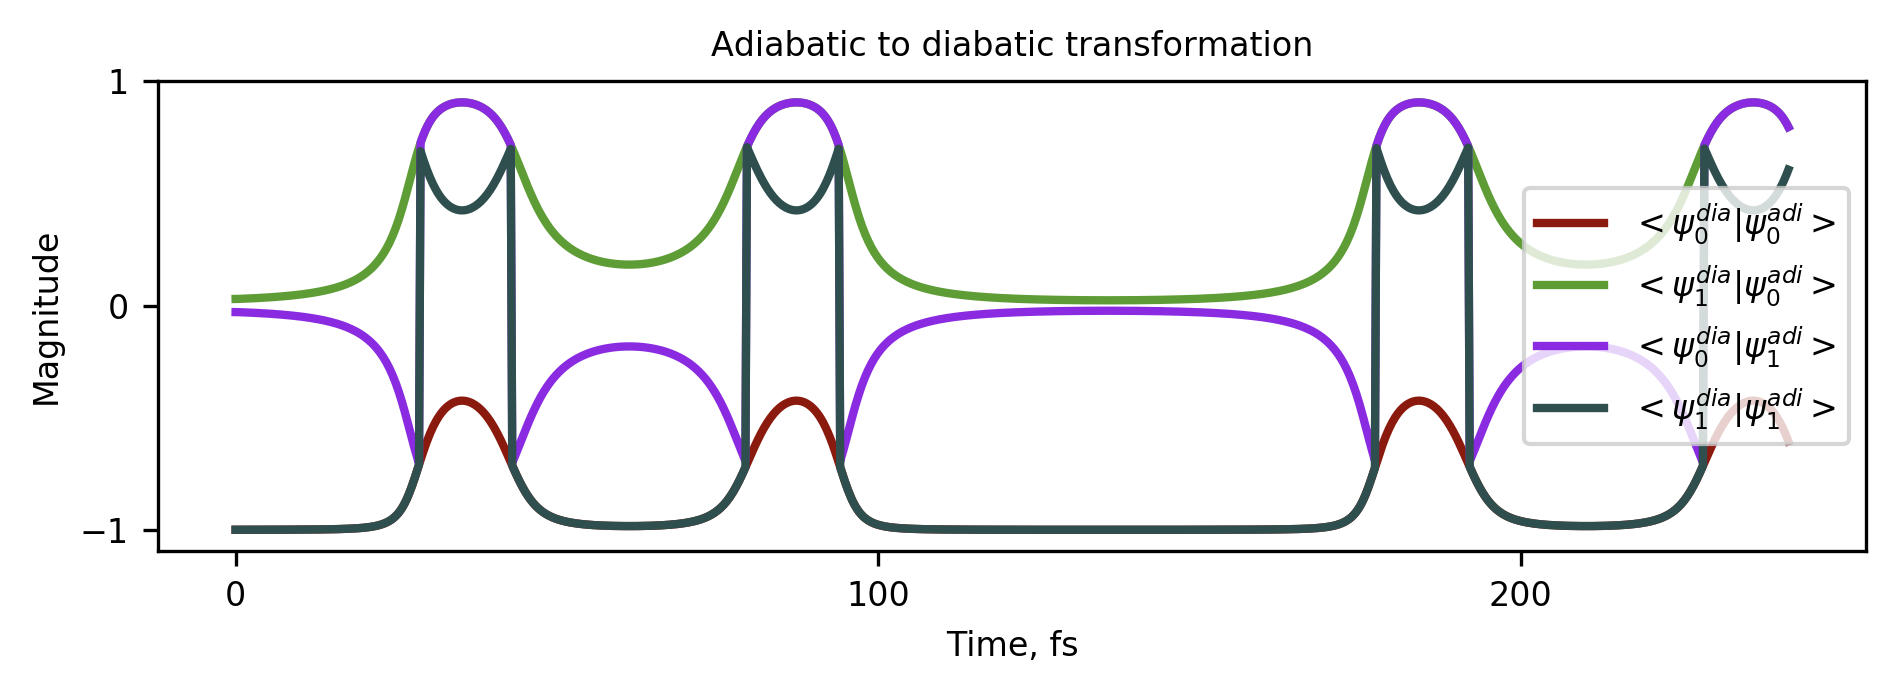

In [11]:
plot_params = { "prefix":"nbra_fssh", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0],
                "which_adi_states":[0,1], "which_dia_states":[0,1],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

### 3.2.2. Method 2<a name="nbra-fssh-2"></a>
[Back to TOC](#TOC)

[Back to NBRA FSSH workflow](#dynamics-nbra-fssh)

In this variation, we set ``"time_overlap_method":1``,

which requests using the time-overlaps from the files. In this case, we don't need to know and process the wavefunctions (which is often the case in atomistic workflows). 

For this version to work, the `compute_model` function must return the `time_overlap_adi` variable. So, the following sections of the `compute_model_nbra` function are relevant:


        #========= Time-overlap matrices ===================
        time_overlap_adi = CMATRIX(nadi, nadi)            
        for i in range(nadi):
            for j in range(nadi):
                time_overlap_adi.set(i,j, complex( f["St/data"][timestep, indx, i, j]) )                

    obj = tmp()
    obj.time_overlap_adi = time_overlap_adi

In [12]:
params_nbra_fssh2 = dict(common_params)

params_nbra_fssh2.update({ "rep_ham":1, "tsh_method":0, 
                           "force_method":0, "nac_update_method":0,
                           "hop_acceptance_algo":31, "momenta_rescaling_algo":0,
                           "time_overlap_method":1
                         } )


model_params_nbra = dict(model_params)
model_params_nbra.update( {"filename":"adiabatic_md/mem_data.hdf", "model":2 } )


run_tsh(params_nbra_fssh2, model_params_nbra, "nbra_fssh2")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

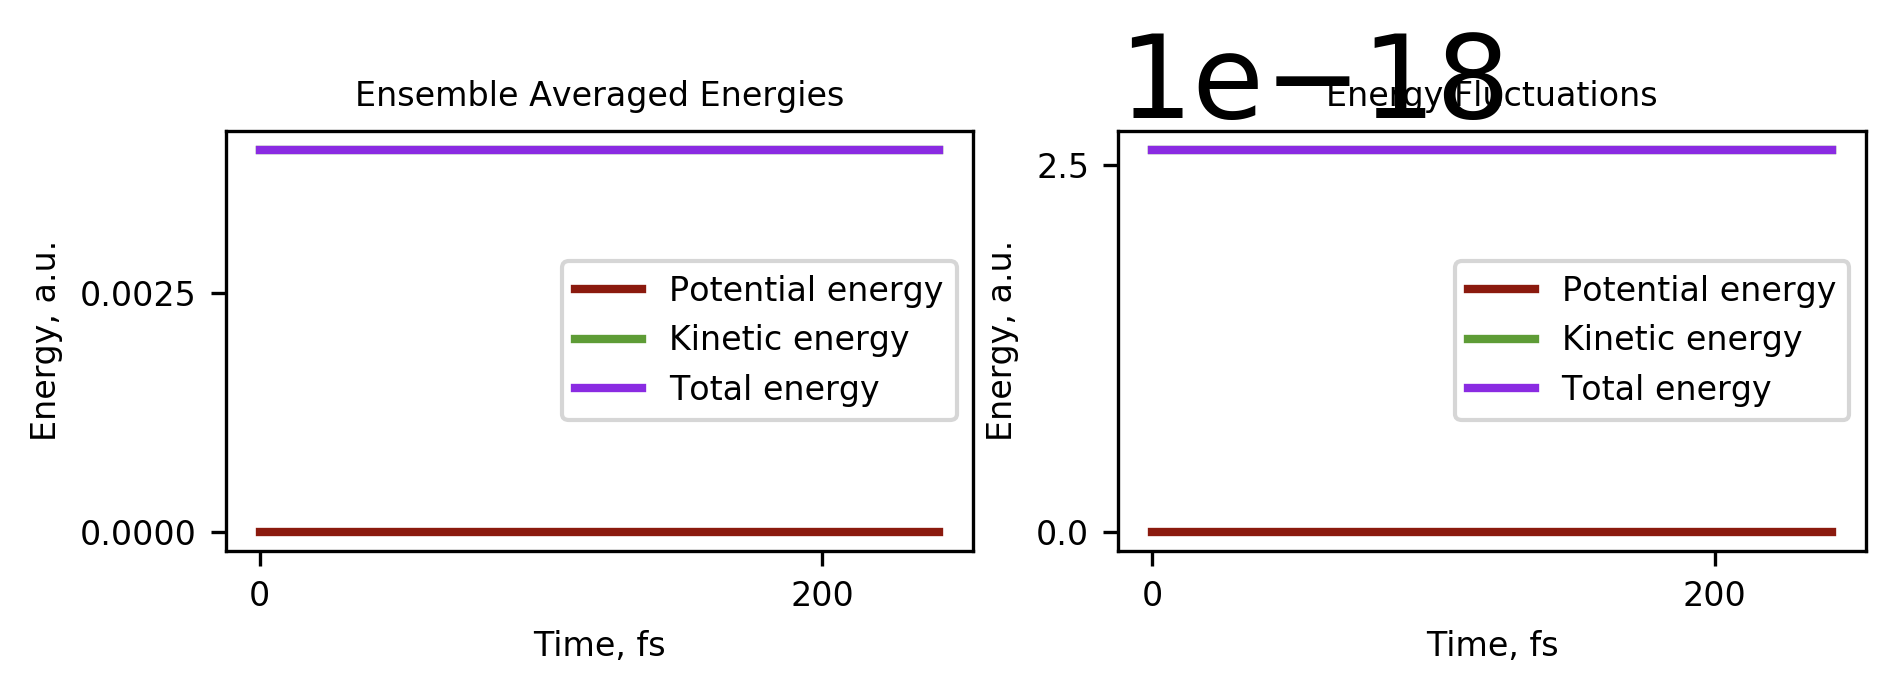

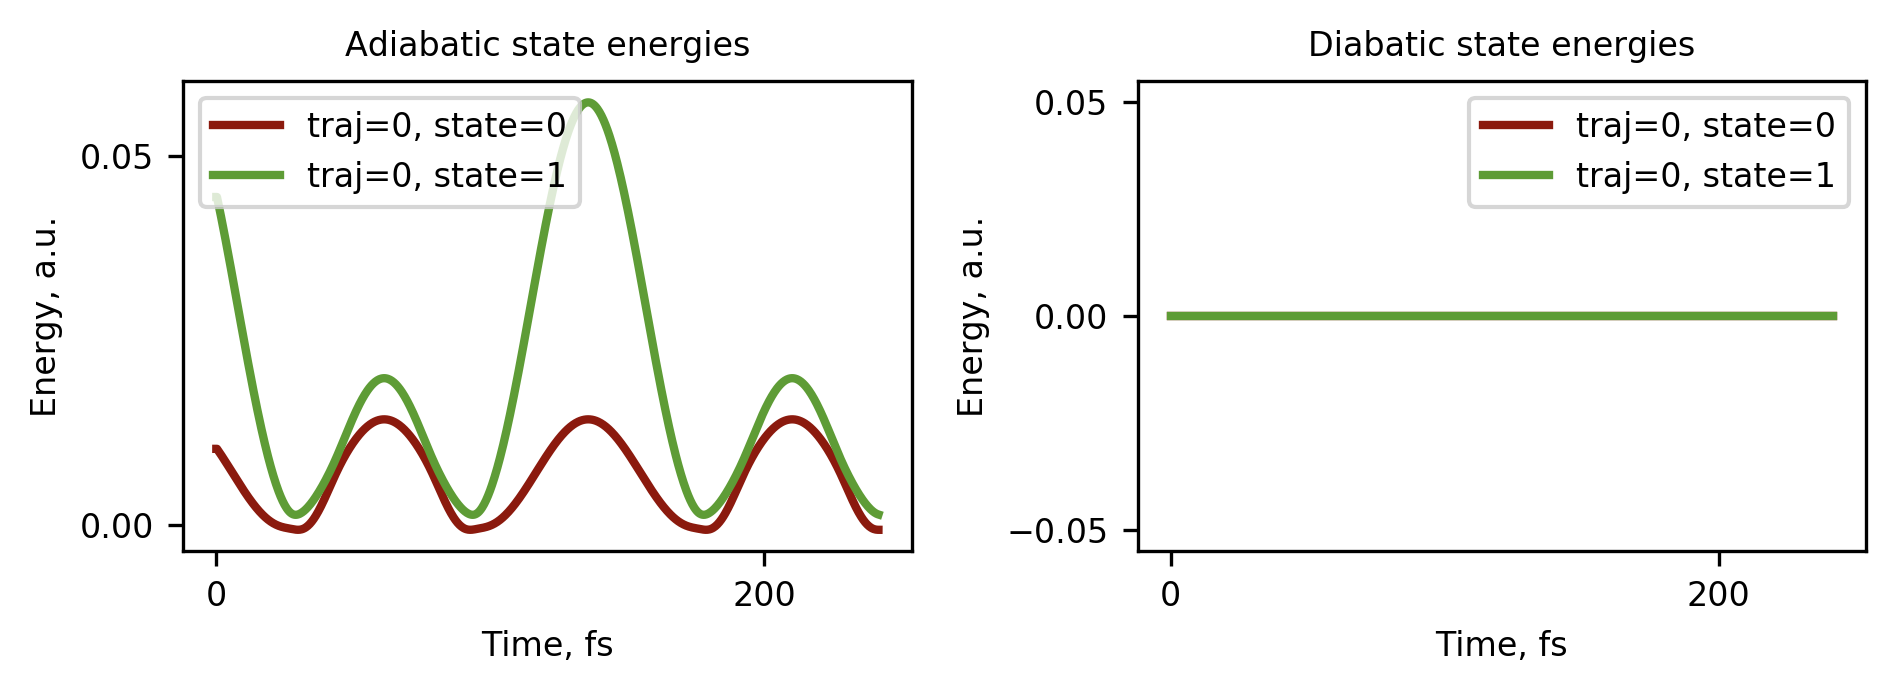

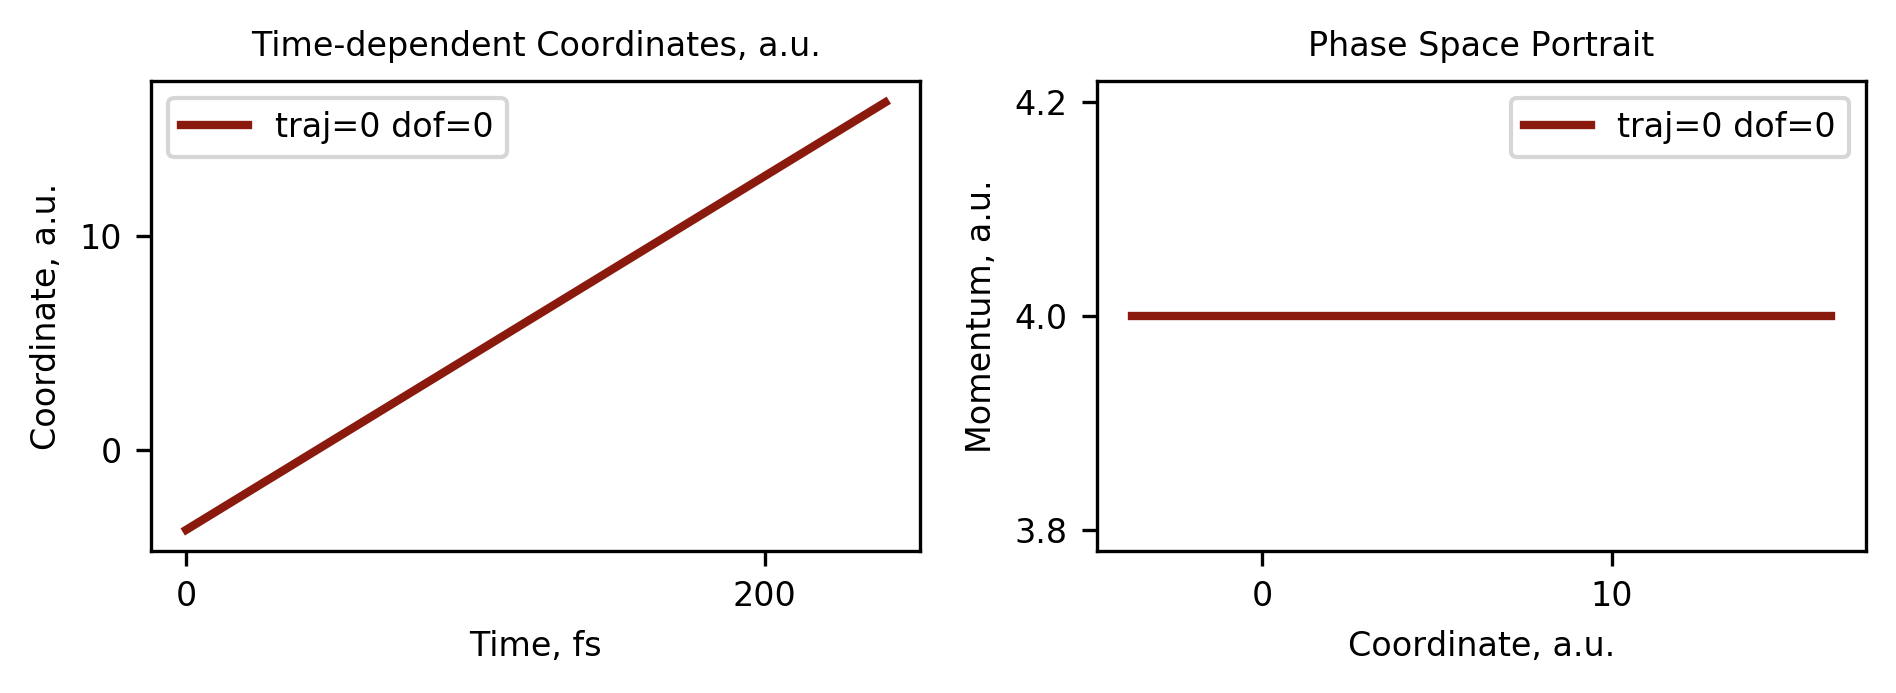

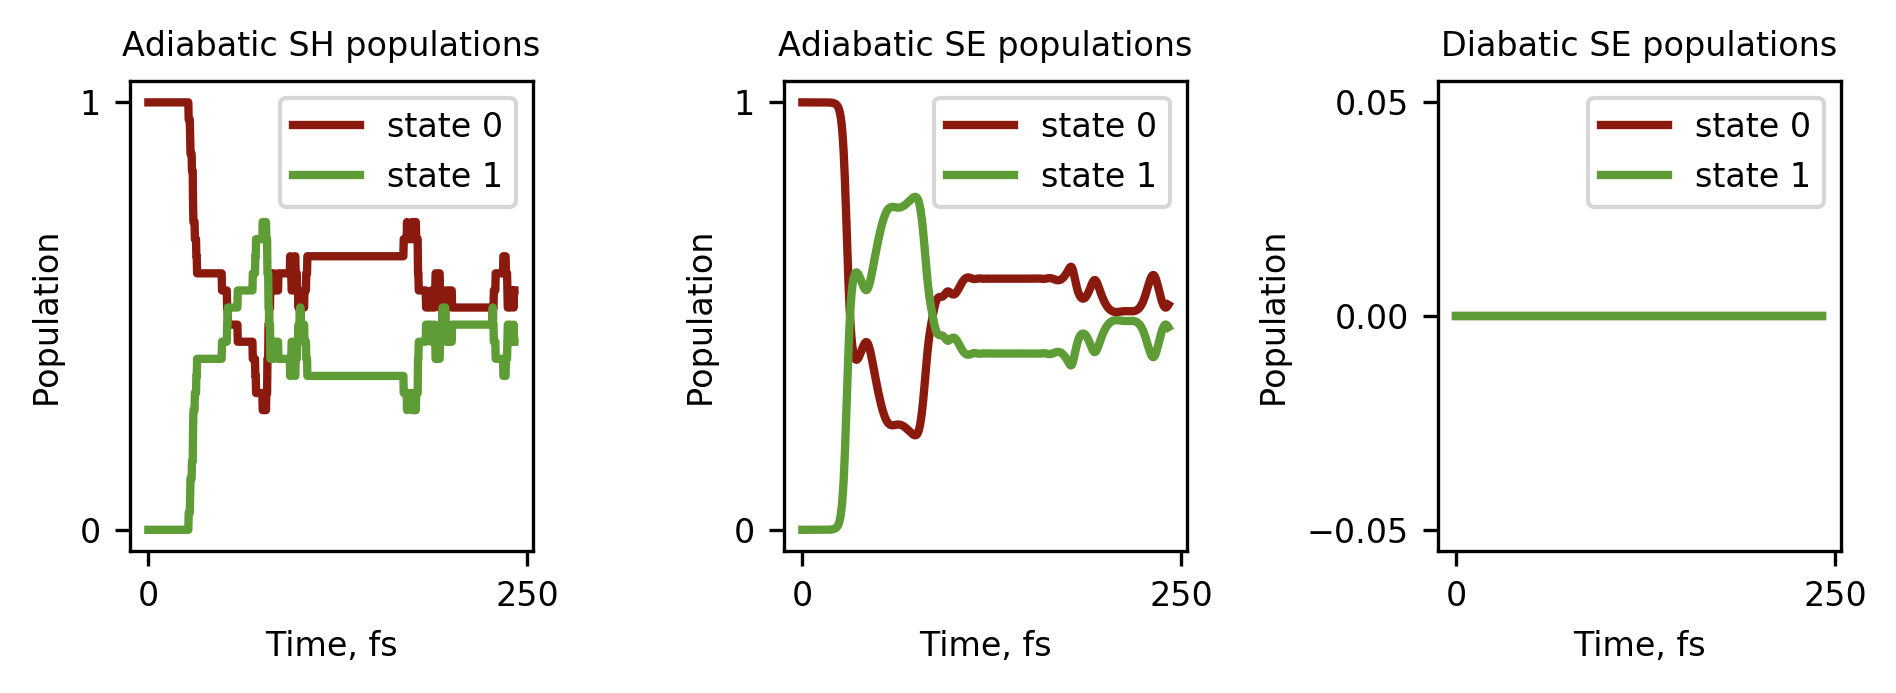

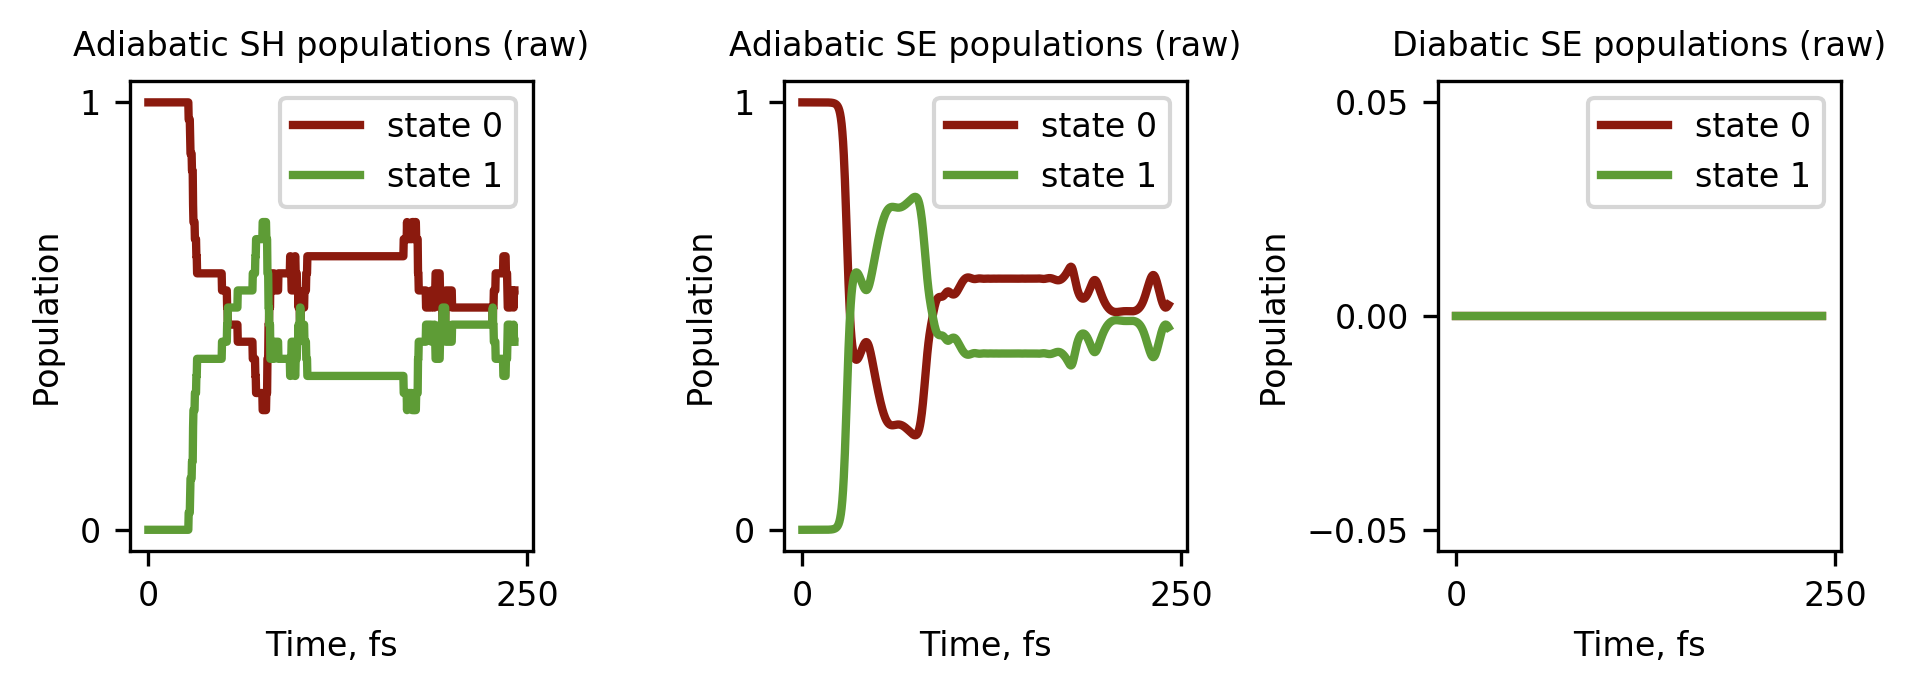

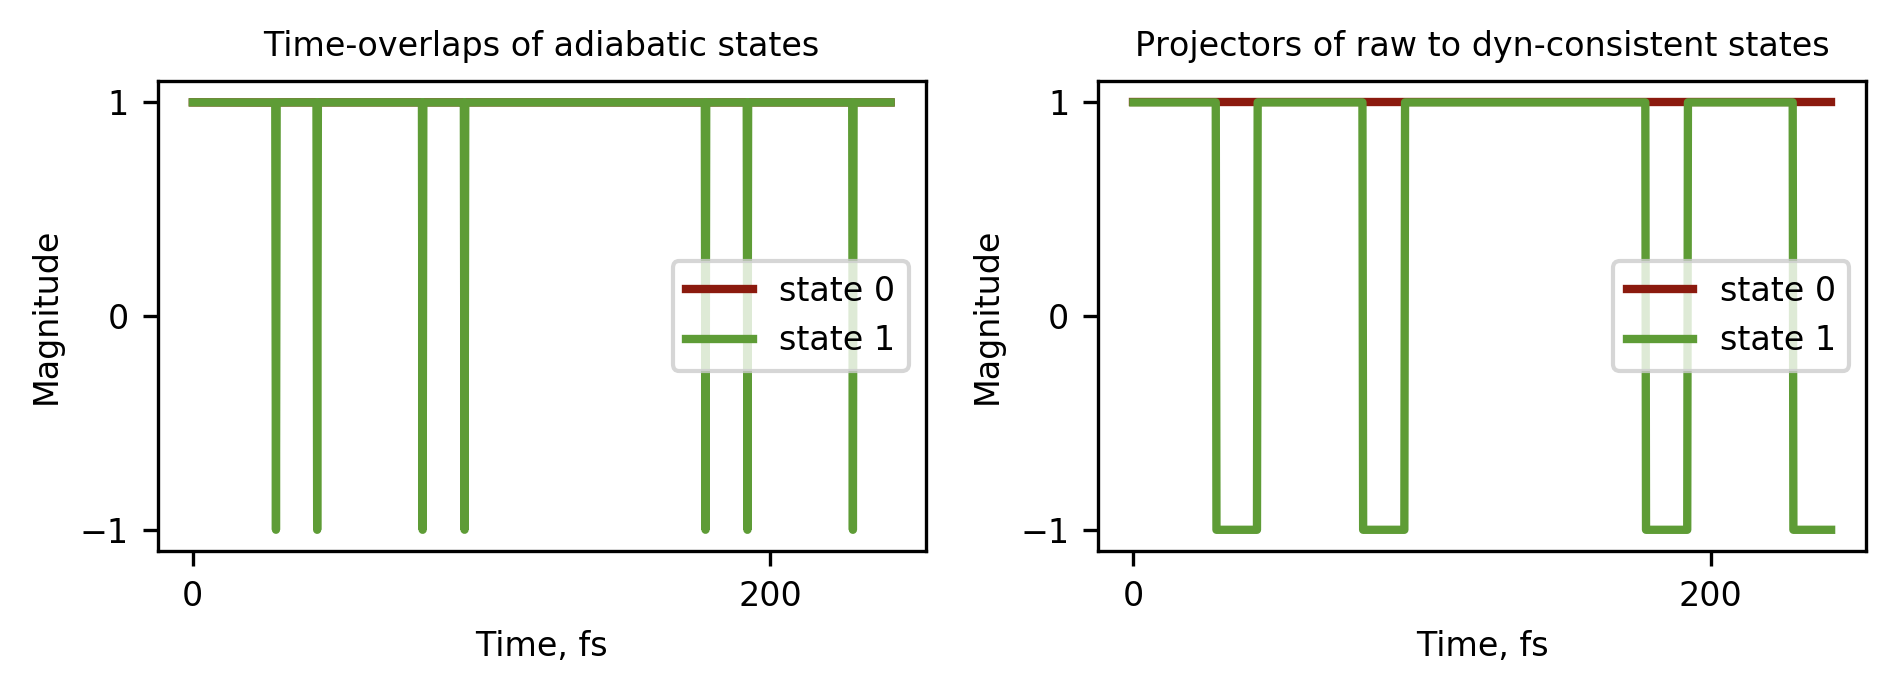

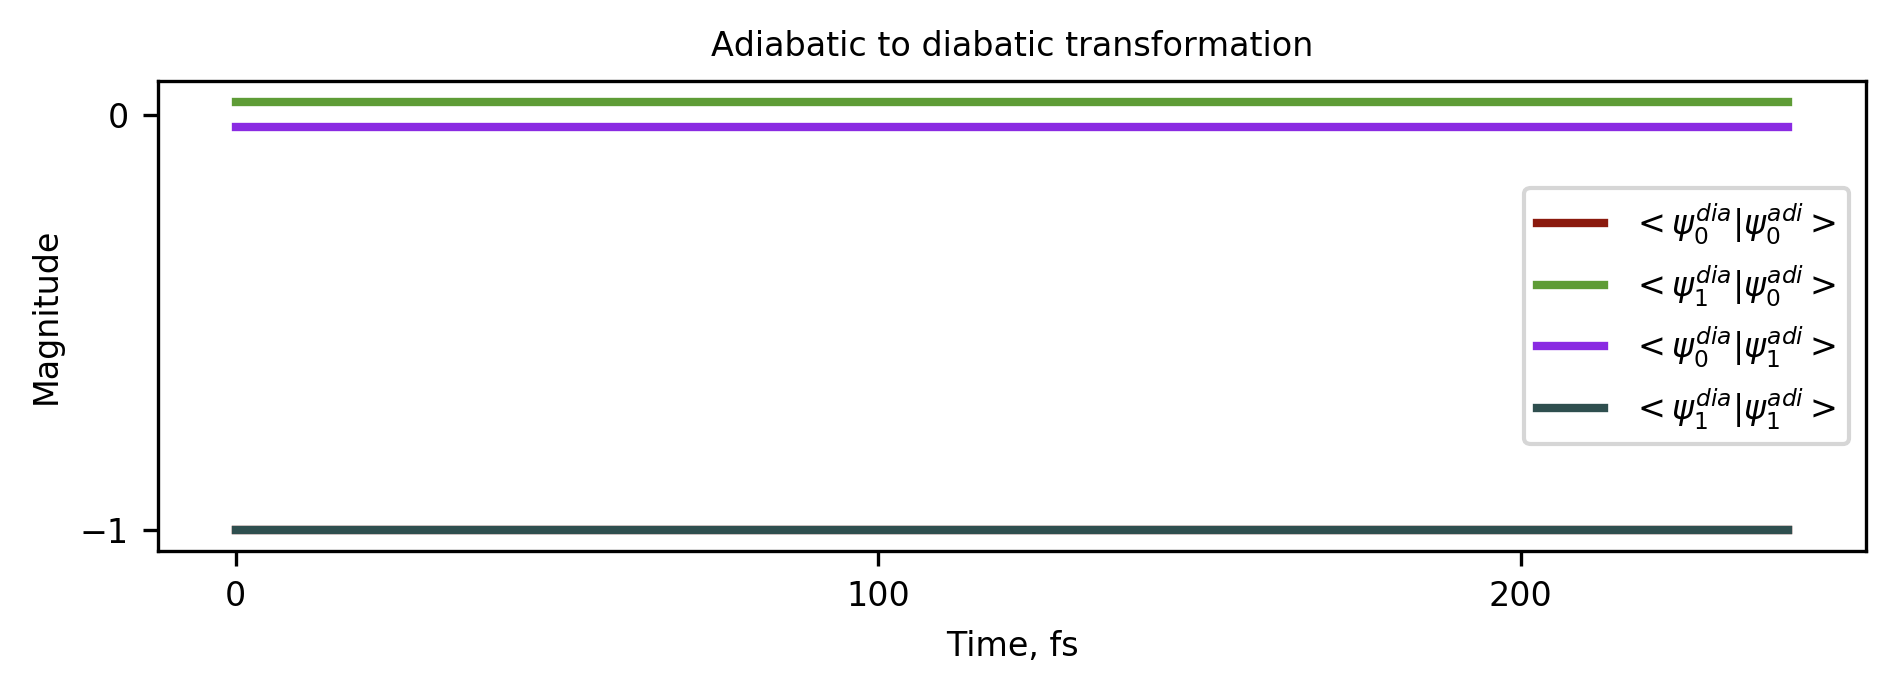

In [13]:
plot_params = { "prefix":"nbra_fssh2", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0],
                "which_adi_states":[0,1], "which_dia_states":[0,1],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)

Note how with this run, fewer panels are informative. This is because the corresponding data are irrelevant (zero or something else, but we don't care too much)

## 3.2. The regular (non-NBRA) TSH dynamics workflow<a name="dynamics-fssh"></a>
[Back to TOC](#TOC)

[Back to Dynamics](#dynamics)

Finally, lets do the non-NBRA (the genuine TSH) dynamics.

Switching between NBRA and non-NBRA is pretty much a matter of the same set of 6 parameters + using a suitable `compute_model` function. Lets revise the changes:

1. ``"rep_ham":0`` (was 1 in the NBRA) - we now rely on the definition of the diabatic Hamiltonian, which would lead to computing the diabatic-to-adiabatic transformation, and hence the NACs and excited state forces. In principle, the non-NBRA can be run with ``"rep_ham":1``, if you can supply all the needed properties (derivative couplings, gradients, adibatic energies)

2. ``"force_method":1`` (was 0 in the NBRA) - now, we need to use the state-specific forces    

3. ``"nac_update_method":1`` (was 0 in the NBRA) - now, we want to update our vibronic Hamiltonians at the runtime to reflect the changing nuclear momenta. Again, in principle, the non-NBRA can be run with this parameter being 0.

4. ``"tsh_method":0`` - we are now doing the FSSH (same as in the NBRA)

5. ``"momenta_rescaling_algo":201`` - now we want to rescale the velocities after the successful hops and reverse them at the frustrated hops

6. ``"hop_acceptance_algo":20`` - the hop acceptance is determined as in the original Tully's paper, but for that to work we need to have the derivative coupling.


Also note how we again use the original model parameters, which will call the built-in `Holstein2` function. 

In [14]:
params_fssh = dict(common_params)

params_fssh.update({"rep_ham":0, "force_method":1,  "nac_update_method":1,
                    "tsh_method":0, "hop_acceptance_algo":20,   "momenta_rescaling_algo":201,               
                    })
  
model_params_fssh = dict(model_params)
    
run_tsh(params_fssh, model_params_fssh, "fssh")

 step= 0
 step= 100
 step= 200
 step= 300
 step= 400
 step= 500
 step= 600
 step= 700
 step= 800
 step= 900
In mem_saver.save_data()
data_name =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector']
keywords =  ['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector', 'Etherm', 'E_NHC']
keys =  dict_keys(['timestep', 'time', 'Ekin_ave', 'Epot_ave', 'Etot_ave', 'dEkin_ave', 'dEpot_ave', 'dEtot_ave', 'Etherm', 'E_NHC', 'states', 'SH_pop', 'SH_pop_raw', 'D_adi', 'D_adi_raw', 'D_dia', 'D_dia_raw', 'q', 'p', 'Cadi', 'Cdia', 'hvib_adi', 'hvib_dia', 'St', 'basis_transform', 'projector'])

Lets plot and analyze the results.

Note:

- the total energy is still conserved very well - a good sign;

- energy gaps are smaller now, which is because we are now more likely to be on other states, which changes the dynamics and makes us explore another regions of the phase space where the gaps may be smaller;

- the phase space portrait shows discontinuities - the signs of the surface hopping

- the SH and SE populations are internally consistent, but are now different from what we have seen in the NBRA case. Well, for this example, the difference isn't that large, but it is still there. 

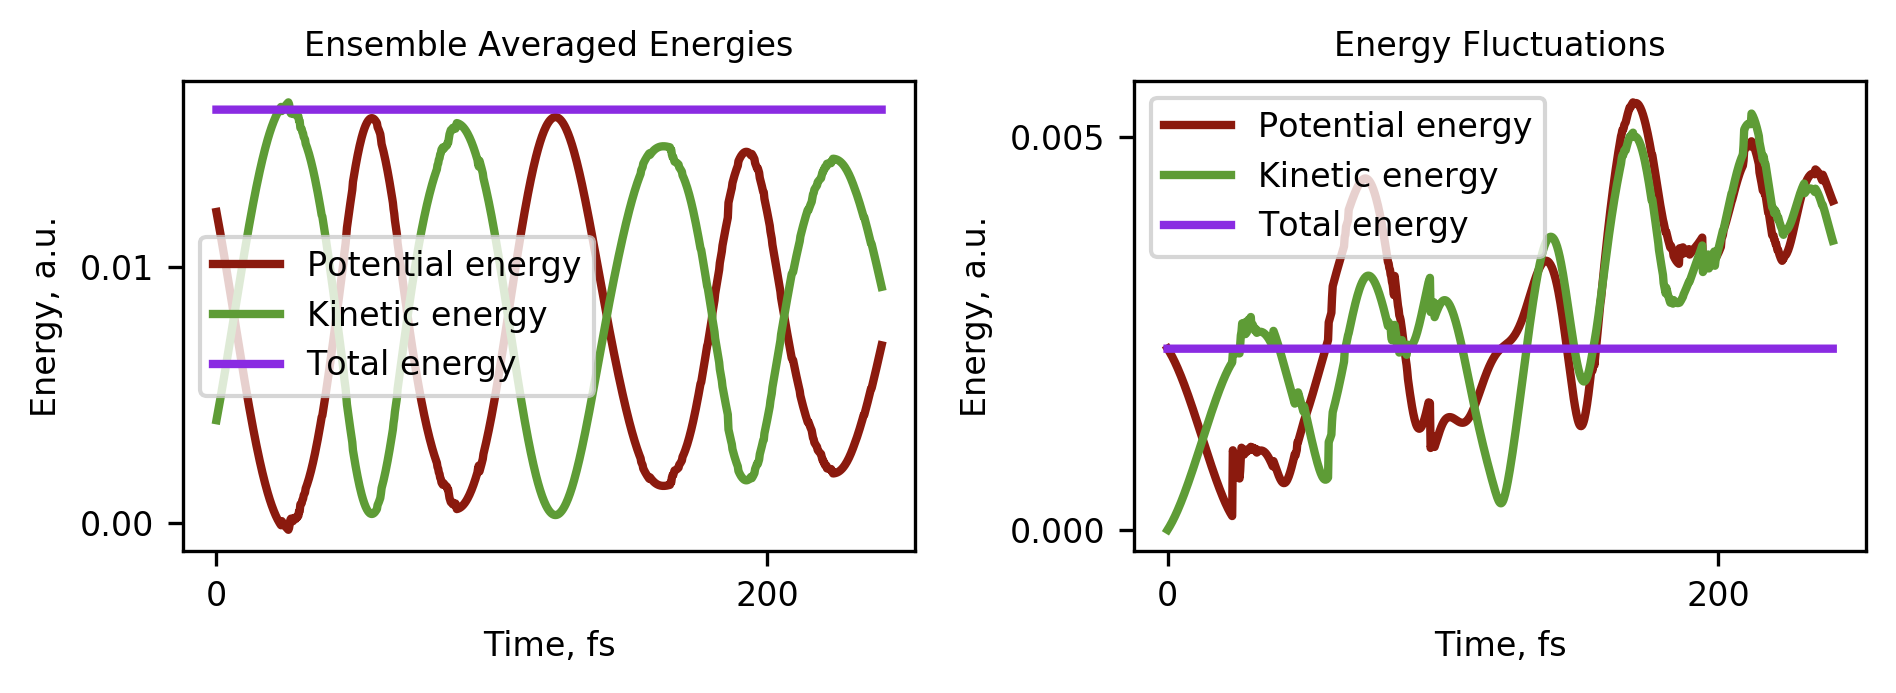

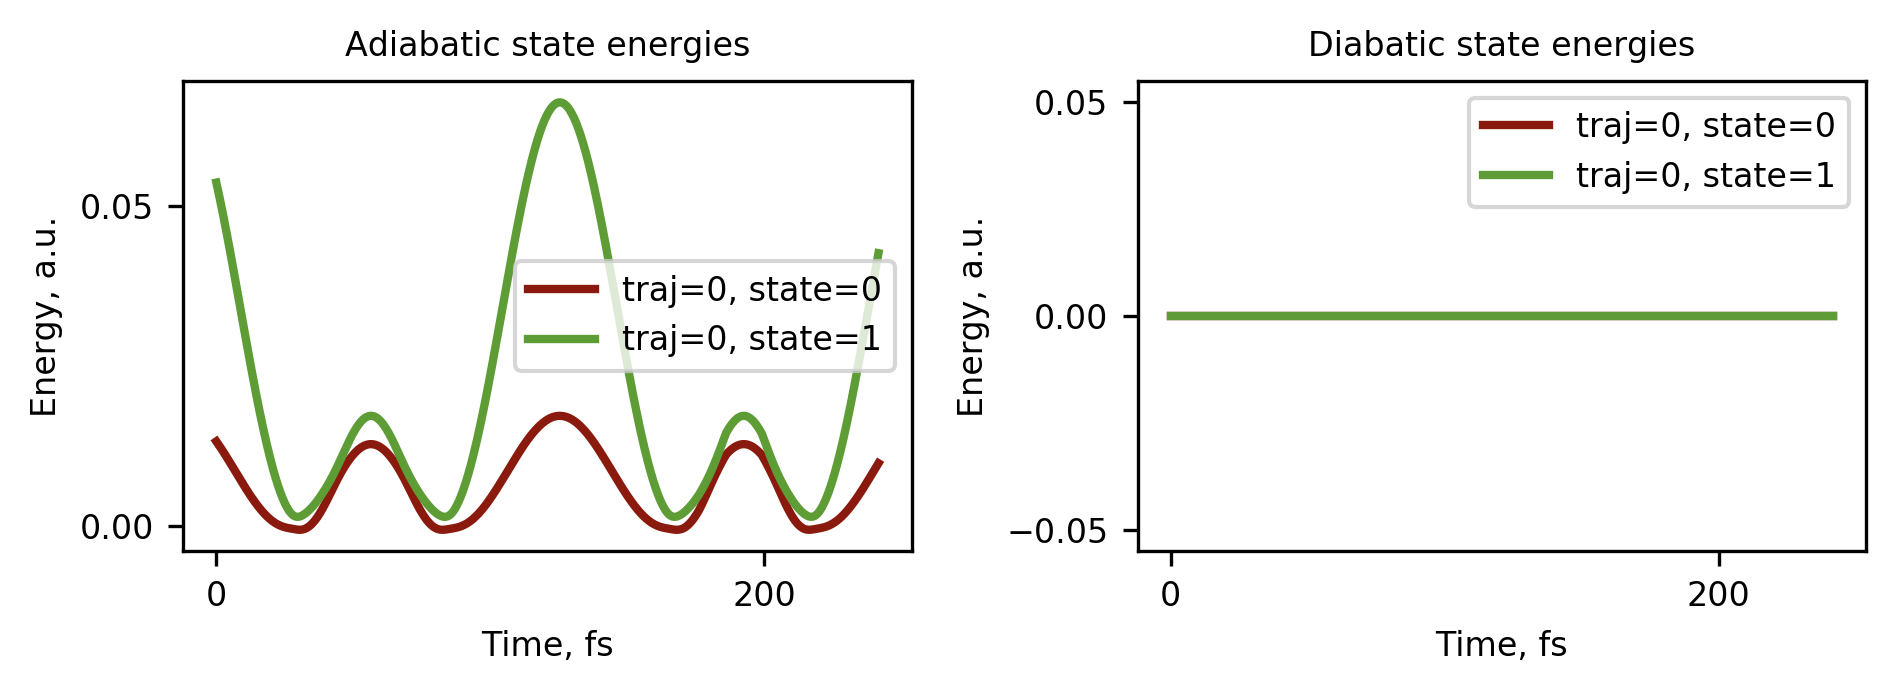

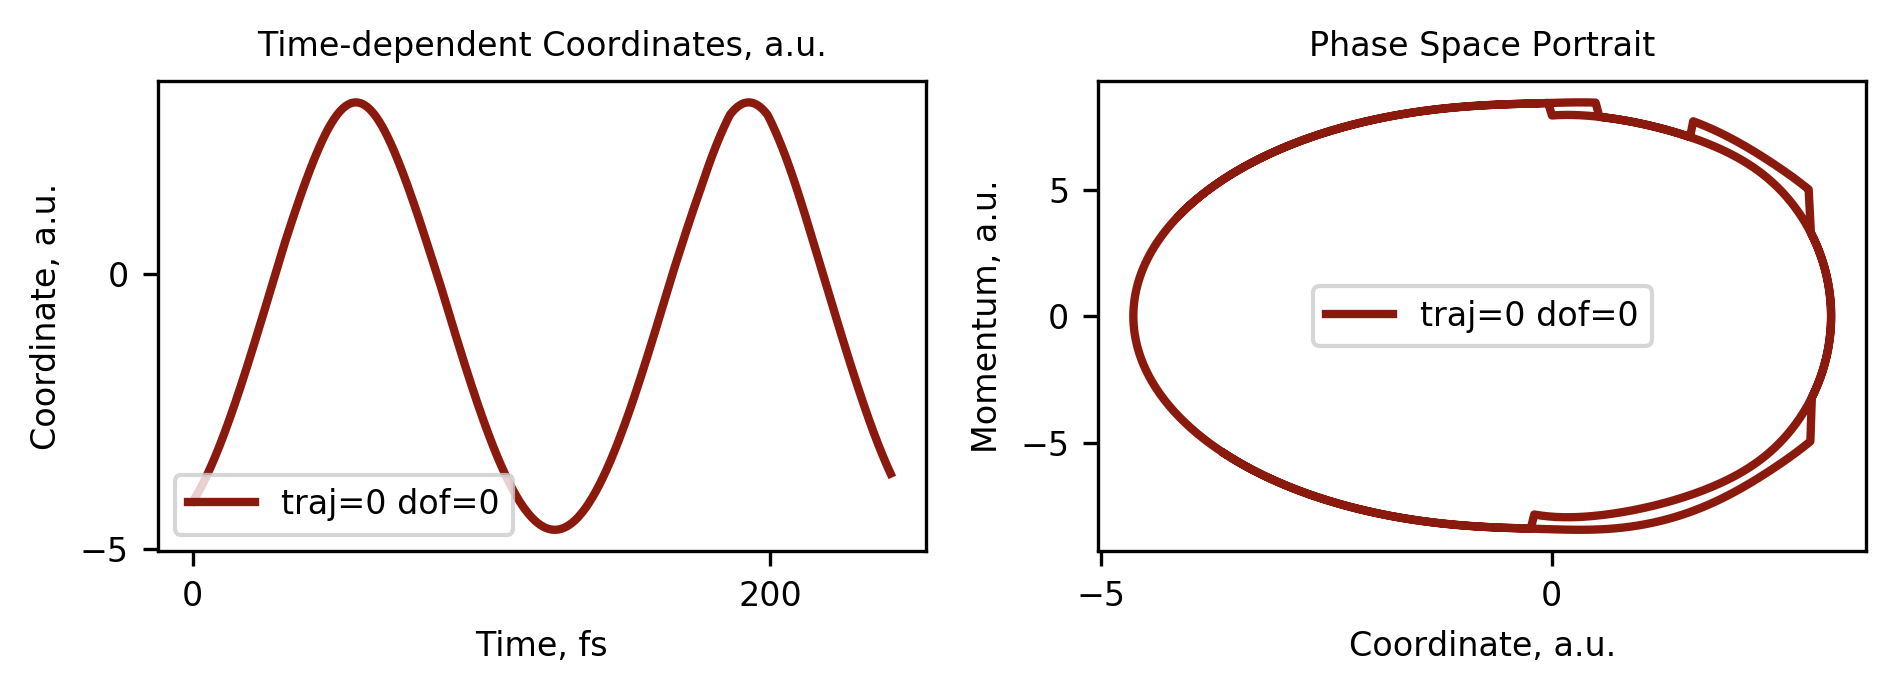

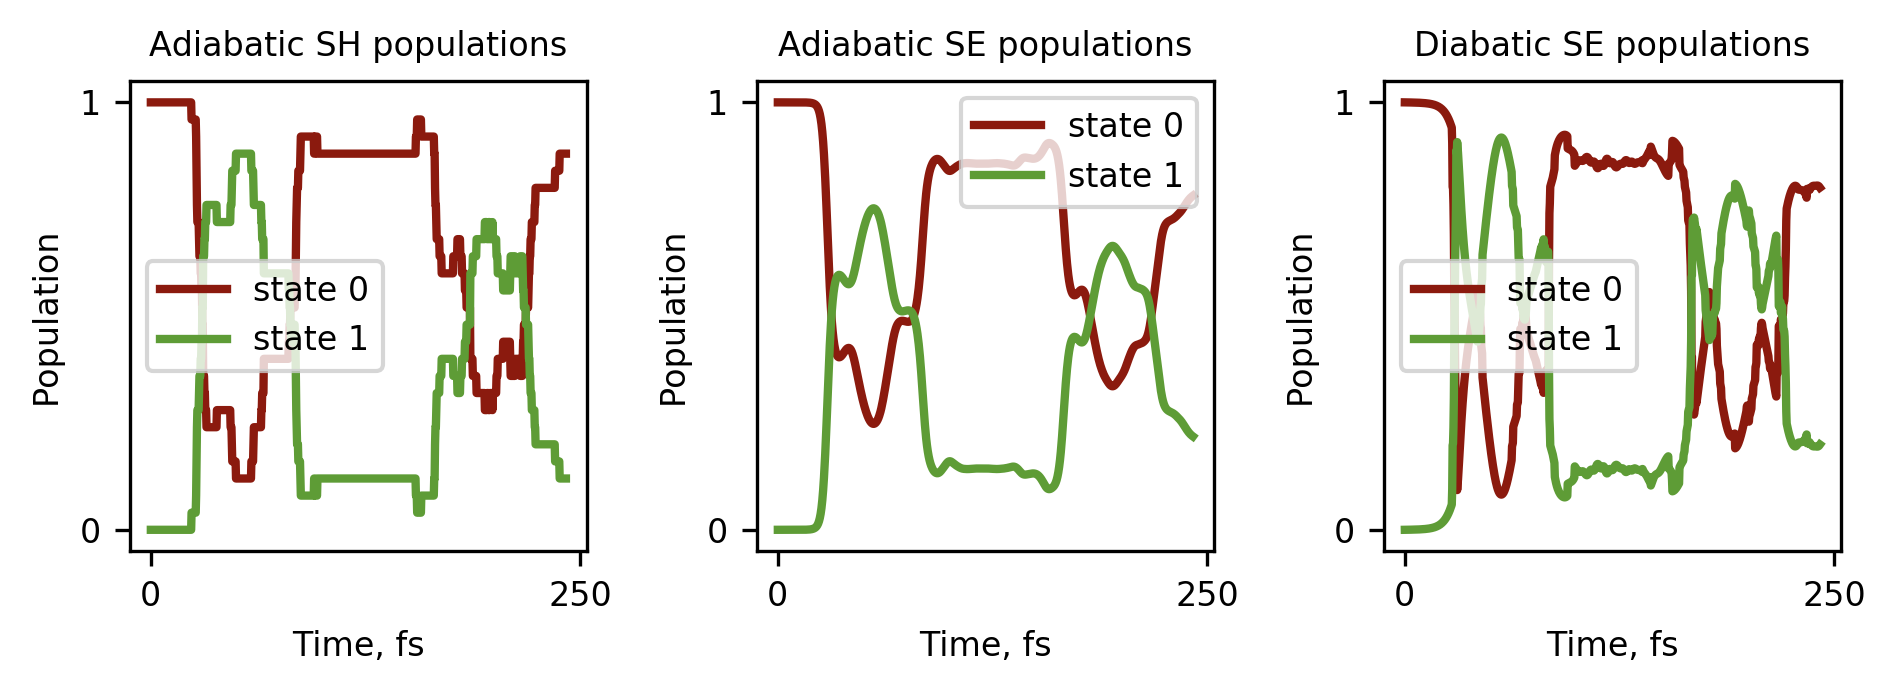

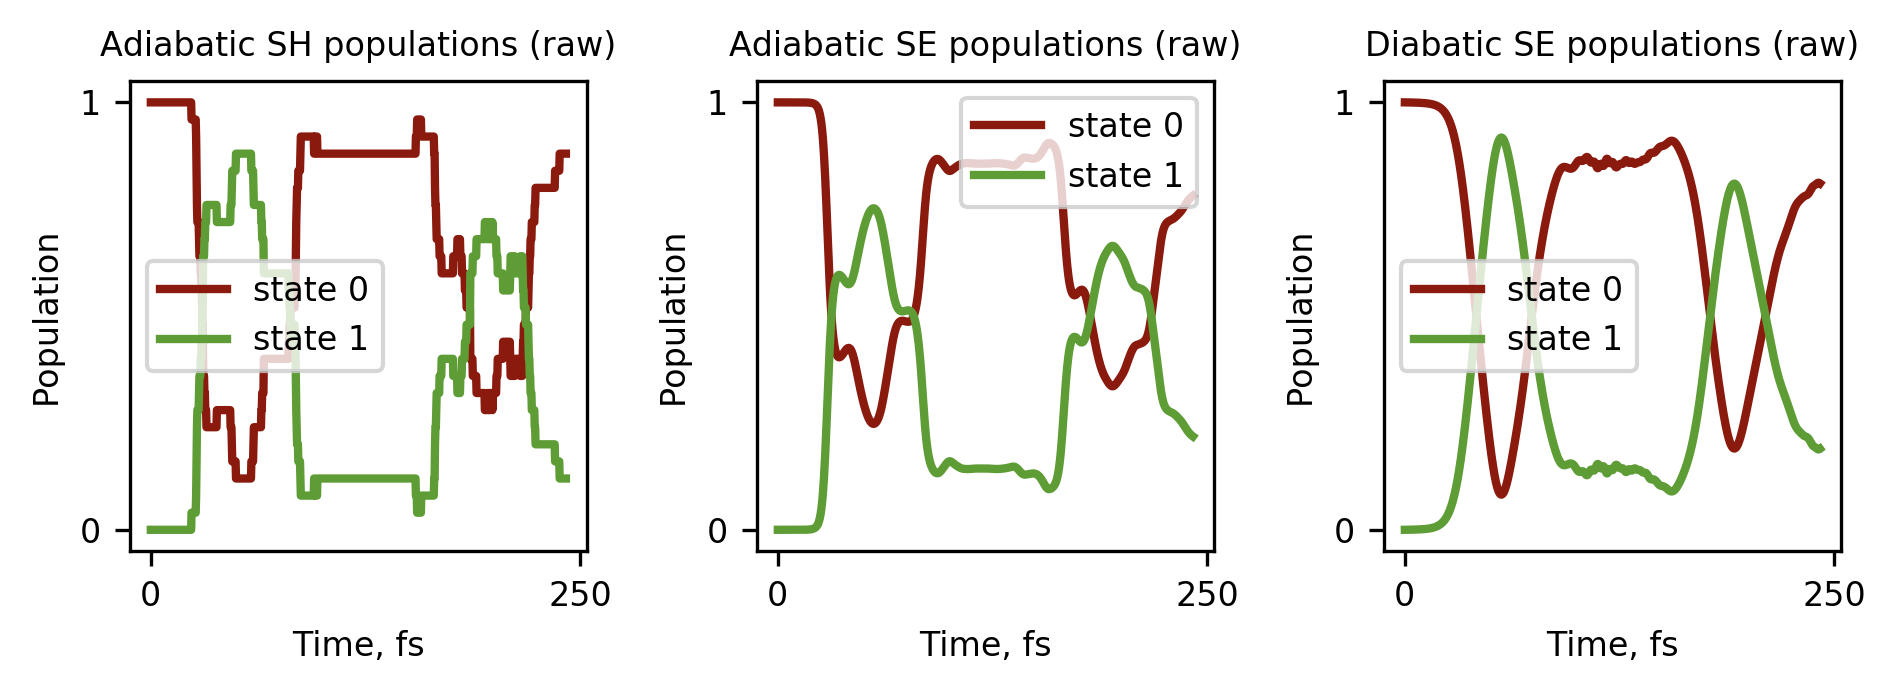

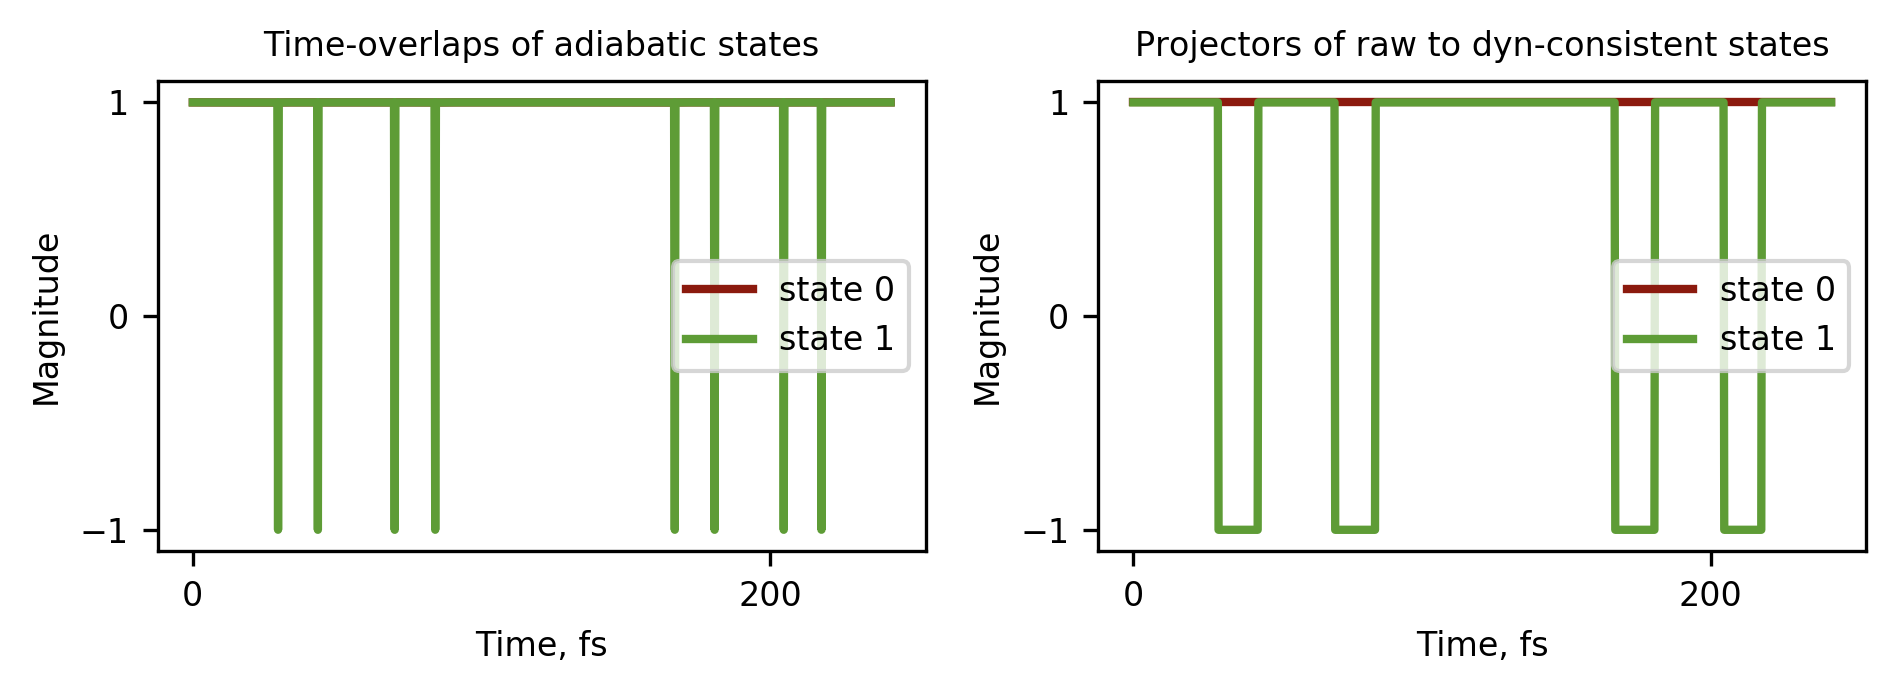

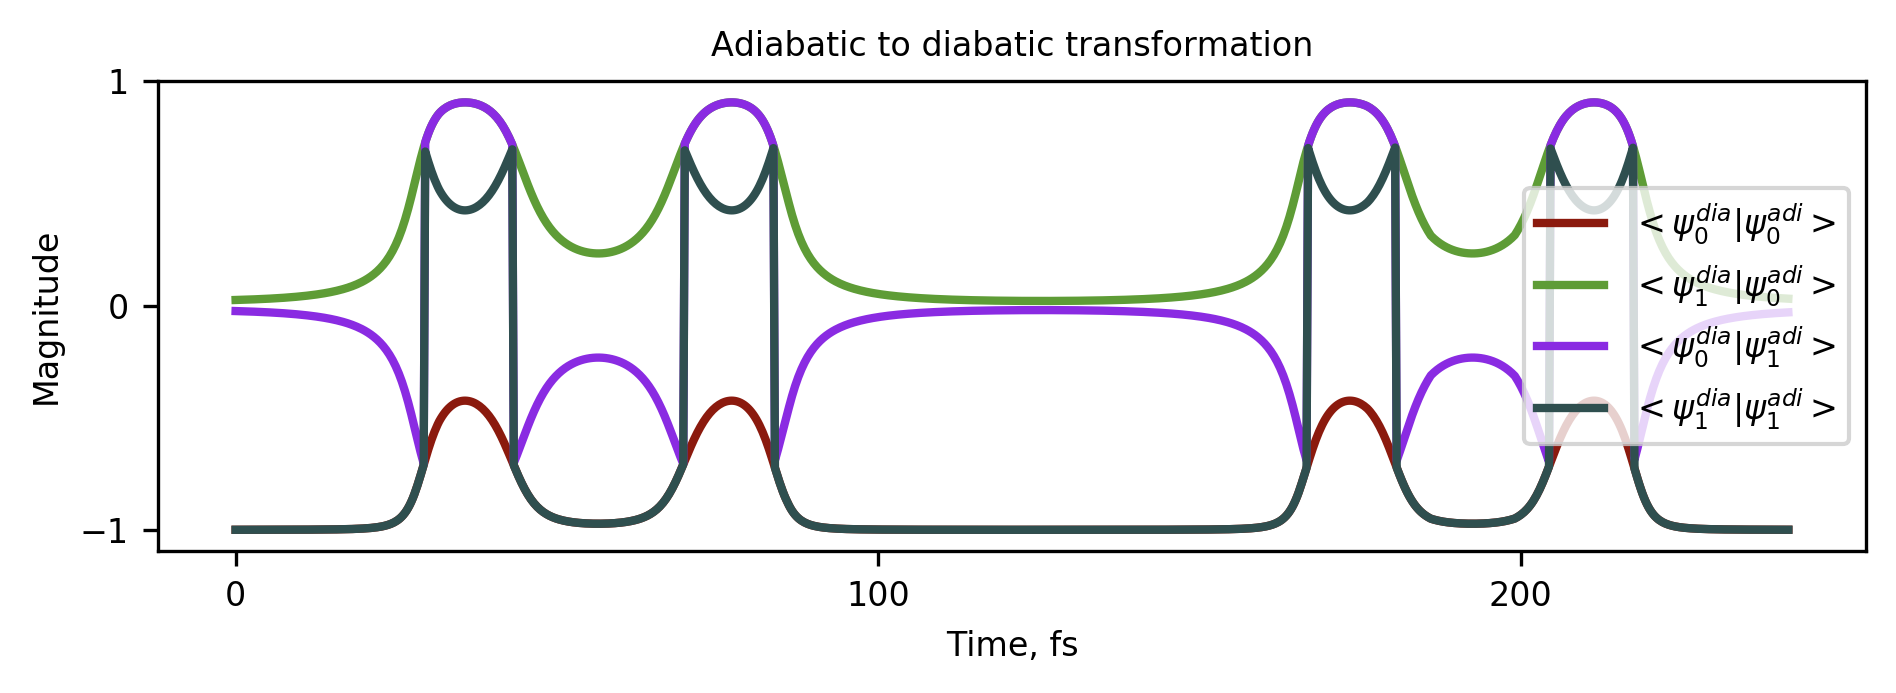

In [15]:
plot_params = { "prefix":"fssh", "filename":"mem_data.hdf", "output_level":4,
                "which_trajectories":[0], "which_dofs":[0],
                "which_adi_states":[0,1], "which_dia_states":[0,1],
               
                "axes_label_fontsize":(8,8), "legend_fontsize":8, 
                "axes_fontsize":(8,8), "title_fontsize":8,
                "which_energies":["kinetic", "potential", "total"],
                "frameon":False,                    
              }

tsh_dynamics_plot.plot_dynamics(plot_params)